future project:
- don't drop GEOID's in dockless; figure out how they work for more accurate analysis
- add kiosk location by council district in bcycle to match dockless


links: 
- bcycle data: https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Trips/tyfh-5r8s
- dockless data: https://data.austintexas.gov/Transportation-and-Mobility/Dockless-Vehicle-Trips/7d8e-dm7r 
- dockless city council map w/ numbers: http://www.austintexas.gov/GIS/CouncilDistrictMap/
- COA micromobility landing page: https://austintexas.gov/micromobility
- City of Austin District Representatives: https://www.austintexas.gov/government
- battery life, source 1: https://www.cnet.com/news/electric-scooters-bikes-dockless-ride-share-bird-lime-jump-spin-scoot/
- battery life, source 2: https://www.washingtonpost.com/local/trafficandcommuting/scooters-we-answer-your-questions-about-this-latest-transportation-trend/2018/11/10/a94b7d94-de03-11e8-85df-7a6b4d25cfbb_story.html?utm_term=.05c93aa0f747
- ojo/scoot vespa info: https://electrek.co/2019/01/22/ojo-electric-scooters/ 
veoride range info: https://news.uark.edu/articles/46123/veoride-bikeshare-program-adds-150-new-e-assist-bikes 
- scooter lifespan: https://mashable.com/article/escooter-lifespan-shared-new-models/ 

In [1]:
#Import libraries
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator
import seaborn as sns
sns.set_style('white')

#ml algos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 30
pd.options.display.max_columns = 30

## This dataset measures data from Austin's micromobility program from April 3, 2018 through June 18, 2019, which was the date I downloaded it from the AustinTexas.gov website. The data is updated on a weekly basis. 

In [3]:
#import csv for Austin B-Cycle Trip data
#commented out
#bcycle = pd.read_csv('Austin_B-Cycle_Trips.csv', encoding='latin1')
bcycle = pd.read_pickle('./Austin_B-Cycle_Trips.pkl')
#bcycle.to_pickle('./Austin_B-Cycle_Trips.pkl')

In [4]:
#import csv for private dockless rideshare co's
#commented out:
#dockless = pd.read_csv('Dockless_Vehicle_Trips.csv', encoding='latin1')
dockless = pd.read_pickle('./Dockless_Vehicle_Trips.pkl')
#dockless.to_pickle('./Dockless_Vehicle_Trips.pkl')

# Section I - CITY OF AUSTIN B-CYCLE BIKE RENTAL PROGRAM

# Data Cleaning: City of Austin B-Cycle Bike Rental Program

## Before the dataset is altered, there are 1,171,610 recorded trips. This value will be used to calculate just how many of the rows dropped after the dataset is cleaned. 

In [5]:
# original number of trips
num_trips = len(bcycle)
print("There are {} trips in this dataset".format(num_trips))

There are 1171610 trips in this dataset


In [6]:
# data clean columns: 
bcycle.columns = bcycle.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop Year and Month since ~50% of the values in both colummns are NaN while the Checkout Date are 100% filled.

In [7]:
bcycle.drop(['month', 'year'], 1, inplace=True)

In [8]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76


## Cleanup -  bicycle_id

In [9]:
bcycle.loc[1077930]

trip_id                                 19000898
membership_type          U.T. Student Membership
bicycle_id                                  303G
checkout_date                         11/18/2018
checkout_time                           22:35:50
checkout_kiosk_id                           2547
checkout_kiosk                  Guadalupe & 21st
return_kiosk_id                             3838
return_kiosk                       Nueces & 26th
trip_duration_minutes                          7
Name: 1077930, dtype: object

In [10]:
bcycle.loc[bcycle.bicycle_id == '318', 'bicycle_id'].count()

0

In [11]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(str)

In [12]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'str'>    1171610
Name: bicycle_id, dtype: int64

In [13]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('G', '')

In [14]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('B', '')

In [15]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('E', '')
bcycle.bicycle_id.value_counts()

951.0    1896
387.0    1861
885.0    1855
925.0    1852
80.0     1844
696.0    1841
839.0    1840
969.0    1831
60.0     1829
281      1826
660.0    1822
37.0     1810
75.0     1808
185.0    1793
661.0    1790
         ... 
988.0      58
14190      49
987.0      17
579         5
15          5
933         5
459         4
393         4
483         4
195         3
176         3
805         2
165         2
974         1
980         1
Name: bicycle_id, Length: 1008, dtype: int64

In [16]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [17]:
bcycle['bicycle_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1171610, dtype: float64>

In [18]:
#confirmed there are 723 NaN values out of 1.17 M
nan_bicycle_id = bcycle.bicycle_id.isnull().sum(axis=0)
nan_bicycle_id_percent = nan_bicycle_id / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_bicycle_id, num_trips, nan_bicycle_id_percent))

There are 723 rides with NaN values out of 1171610 total rides, which is equal to 0.0006170995467775113.


## It is safe to say that we can drop the NaN's in these column.

In [19]:
bcycle = bcycle.dropna(axis=0, subset=['bicycle_id'])

## I'm also creating a new dataframe to store the number of drops rows for future reference

In [20]:
dropped_rows = [nan_bicycle_id]

In [21]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [22]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [23]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'float'>    1170887
Name: bicycle_id, dtype: int64

In [24]:
pd.to_numeric(bcycle['bicycle_id'], downcast='float')

0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1170887, dtype: float32

In [25]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup -  return and checkout kiosk ID's

## i need to see list of all columns with NaNs

In [26]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [27]:

nan_checkout_k = bcycle.checkout_kiosk_id.isnull().sum(axis=0)
nan_checkout_kiosk_id_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_checkout_k, num_trips, nan_checkout_kiosk_id_percent))

There are 23131 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [28]:
nan_return_k = bcycle.return_kiosk_id.isnull().sum(axis=0)
nan_return_kiosk_id_percent = nan_return_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {} percent of the dataframe."
      .format(nan_return_k, num_trips, nan_return_kiosk_id_percent))

There are 24390 rides with NaN values out of 1171610 total rides, which is equal to 0.020817507532369987 percent of the dataframe.


In [29]:
nan_sum_ids = bcycle.apply(lambda row: True if pd.isnull(row['checkout_kiosk_id'])
             or pd.isnull(row['return_kiosk_id']) else False, axis='columns')
nan_sum_ids.sum()
var_sum_ids = nan_sum_ids.sum()

## Altogether, only 3.6% of the dataframe's rows have NaN's values in either the checkout or return kiosk ID, so I'm dropping them. 

In [30]:
percent_kiosks_dropped = var_sum_ids / num_trips
print("There are {} uniquw rows dropped from a total of {}, which is {} percent of the dataset."
      .format(var_sum_ids, num_trips, percent_kiosks_dropped))

There are 42430 uniquw rows dropped from a total of 1171610, which is 0.036215122779764596 percent of the dataset.


In [31]:
dropped_rows = [nan_checkout_k, nan_return_k]
print(dropped_rows)

[23131, 24390]


In [32]:
bcycle = bcycle.dropna(axis=0, subset=['checkout_kiosk_id', 'return_kiosk_id'])

In [33]:
bcycle.isnull().sum()

trip_id                     0
membership_type          6366
bicycle_id                  0
checkout_date               0
checkout_time               0
checkout_kiosk_id           0
checkout_kiosk              0
return_kiosk_id             0
return_kiosk                0
trip_duration_minutes       0
dtype: int64

In [34]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup - membership_type

In [35]:
nan_membership_type = bcycle.membership_type.isnull().sum(axis=0)
nan_membership_type_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_membership_type, num_trips, nan_membership_type_percent))

There are 6366 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [36]:
bcycle = bcycle.dropna(axis=0, subset=['membership_type'])

## Convert checkout_date to a standardized to_datetime

In [37]:
#bcycle['checkout_date'] = pd.to_datetime(bcycle['checkout_date'])

## There is also a mismatch betweent the number of unique Return & Checkout Kiosk and the corresponding ID's

In [38]:
bcycle['checkout_kiosk_id'].nunique()

96

In [39]:
bcycle['checkout_kiosk'].nunique()

100

In [40]:
bcycle['return_kiosk_id'].nunique()

96

In [41]:
bcycle['return_kiosk'].nunique()

99

## Memory

In [42]:
bcycle.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122091 entries, 0 to 1171609
Data columns (total 10 columns):
trip_id                  1122091 non-null int64
membership_type          1122091 non-null object
bicycle_id               1122091 non-null float64
checkout_date            1122091 non-null object
checkout_time            1122091 non-null object
checkout_kiosk_id        1122091 non-null float64
checkout_kiosk           1122091 non-null object
return_kiosk_id          1122091 non-null float64
return_kiosk             1122091 non-null object
trip_duration_minutes    1122091 non-null int64
dtypes: float64(3), int64(2), object(5)
memory usage: 437.7 MB


things to reduce
bicycle id-> int 8
checkout ID-> int 16
return ID-> int 16
trip duration-> int 16
month-> int 8
year-> int 16

get dummies
membership
checkout kiosk
return kiosk

## I did a quick calculation of the average memory usage per column to verify...and it's a lot

In [43]:
# memory calc for B cycles data set
for dtype in ['float','int','object']:
    selected_dtype = bcycle.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 65.81MB


In [44]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [45]:
# Created a function to save time
 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series 
        usage_b = pandas_obj.memory_usage(deep=True)
        # convert bytes to megabytes
    usage_mb = usage_b / 1024 ** 2
    return usage_mb

In [46]:
bcycle_int = bcycle.select_dtypes(include=['int'])
converted_int = bcycle_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(bcycle_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([bcycle_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

25.68262481689453
19.2619686126709


,before,after
uint16,NaN,1.0
int64,2.0,NaN
uint64,NaN,1.0


## Downcast columns

In [47]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

In [48]:
bcycle['trip_id'] = pd.to_numeric(bcycle['trip_id'], errors='ignore', downcast='integer')

In [49]:
bcycle['bicycle_id'] = pd.to_numeric(bcycle['bicycle_id'], errors='ignore', downcast='integer')

In [50]:
bcycle['checkout_kiosk_id'] = pd.to_numeric(bcycle['checkout_kiosk_id'], errors='ignore', downcast='integer')

In [51]:
bcycle['return_kiosk_id'] = pd.to_numeric(bcycle['return_kiosk_id'], errors='ignore', downcast='integer')

In [52]:
bcycle['trip_duration_minutes'] = pd.to_numeric(bcycle['trip_duration_minutes'], errors='ignore', downcast='integer')

In [53]:
bcycle.dtypes

trip_id                   int64
membership_type          object
bicycle_id                int16
checkout_date            object
checkout_time            object
checkout_kiosk_id         int16
checkout_kiosk           object
return_kiosk_id           int16
return_kiosk             object
trip_duration_minutes     int16
dtype: object

## Add column measuring time in seconds to match Dockless dataset

In [54]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_minutes'] * 60

In [55]:
bcycle.head(2)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds
0,9900285854,Annual (San Antonio B-cycle),207,10/26/2014,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,10/26/2014,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480


## Convert to positive time to eliminate negative time errors

In [56]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_seconds'].abs()

In [56]:
bcycle['trip_duration_minutes'] = bcycle['trip_duration_minutes'].abs()

## Eliminate whitespaces in kiosk_ids

In [57]:
bcycle['checkout_kiosk'] = bcycle['checkout_kiosk'].str.strip()
bcycle['return_kiosk'] = bcycle['return_kiosk'].str.strip()
pd.set_option('display.max_rows', 150)
bcycle.sort_values(by=['checkout_kiosk']).checkout_kiosk.unique()

array(['10th & Red River', '11th & Salina', '11th & San Jacinto',
       '13th & San Antonio', '17th & Guadalupe', '21st & Speedway @PCL',
       '21st & University', '22nd & Pearl', '23rd & Rio Grande',
       '23rd & San Jacinto @ DKR Stadium', '2nd & Congress', '3rd & West',
       '4th & Congress', '5th & Bowie', '5th & Campbell',
       '5th & San Marcos', '6th & Chalmers', '6th & Congress',
       '6th & Navasota St.', '8th & Congress', '8th & Guadalupe',
       '8th & Lavaca', 'ACC - Rio Grande & 12th',
       'ACC - West & 12th Street', 'Barton Springs & Riverside',
       'Barton Springs @ Kinney Ave', 'Barton Springs Pool',
       'Boardwalk West', 'Brazos & 6th', 'Bullock Museum @ Congress & MLK',
       'Capital Metro HQ - East 5th at Broadway',
       'Capitol Station / Congress & 11th', 'City Hall / Lavaca & 2nd',
       'Congress & Cesar Chavez', 'Convention Center / 3rd & Trinity',
       'Convention Center / 4th St. @ MetroRail', 'Davis at Rainey Street',
       'Dean 

## Convert to checkout date and time to Unix timestamp

In [58]:
bcycle["unix_checkout_time"] = bcycle["checkout_date"].map(str) + " " + bcycle["checkout_time"]

In [59]:
# import
from datetime import datetime
# set the parameter for how the date is being interpretted
merge_time = datetime.strptime('04/29/2019 05:30:00', '%m/%d/%Y %H:%M:%S')
type(merge_time)
# how i want the time coverted to (seconds)
merge_time.strftime('%s')
# define unix timestamp function
def bcycle_to_timestamp(str):
    merge_time = datetime.strptime(str, '%m/%d/%Y %H:%M:%S')
    return merge_time.strftime('%s')

# test that it worked
bcycle_to_timestamp('04/29/2019 05:30:00')
bcycle['unix_checkout_time'] = bcycle.unix_checkout_time.apply(bcycle_to_timestamp)

## Create Hour Feature

In [60]:
# create new column for hour
bcycle['hour'] = bcycle['checkout_time']
# set the parameter for how the date is being interpretted
hour_feature = datetime.strptime('05:30:00', '%H:%M:%S')
# how i want the time coverted to (hour)
hour_feature.strftime('%H')
# define unix timestamp function
def bcycle_to_hour(str):
    hour_feature = datetime.strptime(str, '%H:%M:%S')
    return hour_feature.strftime('%H')

bcycle['hour'] = bcycle.hour.apply(bcycle_to_hour)

## Create Month Feature

In [61]:
# create new column for month
bcycle['month'] = bcycle['checkout_date']
# set the parameter for how the date is being interpretted
month_feature = datetime.strptime('04/29/2019', '%m/%d/%Y')
# how i want the time coverted to (hour)
month_feature.strftime('%m')
# define unix timestamp function
def bcycle_to_month(str):
    month_feature = datetime.strptime(str, '%m/%d/%Y')
    return month_feature.strftime('%m')

bcycle['month'] = bcycle.month.apply(bcycle_to_month)

## Create Year Feature

In [62]:
# create new column for year
bcycle['year'] = bcycle['checkout_date']
# set the parameter for how the date is being interpretted
year_feature = datetime.strptime('04/29/2019', '%m/%d/%Y')
# how i want the time coverted to (year)
year_feature.strftime('%Y')
# define unix timestamp function
def bcycle_to_year(str):
    year_feature = datetime.strptime(str, '%m/%d/%Y')
    return year_feature.strftime('%Y')

bcycle['year'] = bcycle.year.apply(bcycle_to_year)

## Create Day of Week

In [63]:
from datetime import datetime
# create new column for day of week
bcycle['day_of_week'] = bcycle['checkout_date']
# set the parameter for how the date is being interpretted
weekday_feature = datetime.strptime('04/29/2019', '%m/%d/%Y')
# how i want the time coverted to (year)
weekday_feature.strftime('%w')
# define unix timestamp function
def bcycle_to_weekday(str):
    weekday_feature = datetime.strptime(str, '%m/%d/%Y')
    return weekday_feature.strftime('%w')

bcycle['day_of_week'] = bcycle.day_of_week.apply(bcycle_to_weekday)

## Downcast new columns to integers

In [297]:
# convert to integer
bcycle['unix_checkout_time'] = pd.to_numeric(bcycle['unix_checkout_time'], errors='ignore', downcast='integer')
bcycle['hour'] = pd.to_numeric(bcycle['hour'], errors='ignore', downcast='integer')
bcycle['month'] = pd.to_numeric(bcycle['month'], errors='ignore', downcast='integer')
bcycle['year'] = pd.to_numeric(bcycle['year'], errors='ignore', downcast='integer')
bcycle['day_of_week'] = pd.to_numeric(bcycle['day_of_week'], errors='ignore', downcast='integer')

## Drop Checkout time & date

In [65]:
# drop checkout date 
bcycle.drop('checkout_date', 1, inplace=True)
# drop checkout time 
bcycle.drop('checkout_time', 1, inplace=True)

## Drop Kiosks

In [66]:
# drop checkout date 
#bcycle.drop('checkout_kiosk', 1, inplace=True)
# drop checkout time 
#bcycle.drop('return_kiosk', 1, inplace=True)

## Save the new cleaned dataframe to csv for easier use.

In [298]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer,trip_type
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1,15323.63,0


In [57]:
#bcycle.to_csv('bcycle_cleaned')

#bcycle.to_pickle('./Austin_B-Cycle_cleaned.pkl')

#bcycle = pd.read_pickle('./Austin_B-Cycle_cleaned.pkl')

# Visualization & Exploration: City of Austin B-Cycle Bike Rental Program
## One issue we have with the Bcycle dataset is that while we do know the specific start and end location of each ride, we don't know know the actual distance traveled on any ride. 
## In the Dockless dataset we have the opposite problem: accurate distance traveled but no location specific information with start and end location. While we can't use the distance, we will use the ride duration as a proxy.
## We have a very long tail distribution, with the maximum ride being 10,981 minutes!

In [58]:
bcycle['trip_duration_minutes'].max()

10981

## As expected, the tail is too long to get a meaningful view of the distribution.

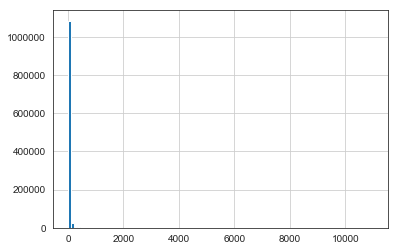

In [59]:
bcycle.trip_duration_minutes.hist(bins=100)

## According to Austin BCycle, no bike is supposed to be rented for more than 24 hours. Furthermore, "Checkouts lasting longer than 60 minutes will be charged an additional fee of 4 dollars(plus tax) for each additional 30 minutes past the first hour of a checkout..."

source: https://austinbcycle.com/how-it-works/faqs 

## Being charged 4 dollars every 30 minutes for 23 hours = 184 + 15.18 in tax (8.25% sales tax), or 199.18 dollars (!!!). That is a strong incentive to not have a bike ride last that long especially with other day-rental bike businesses available.

## With all of this in mind, I will cap what we could consider a real ride as up to 24 hours, which is 1,440 minutes. 

## I divided the range into four equal sections to visualize the distribution. It seems around the 1.5-2 hour mark (90-120 minutes) is when the long tail flattens significantly. Past then, the distribution becomes jagged.

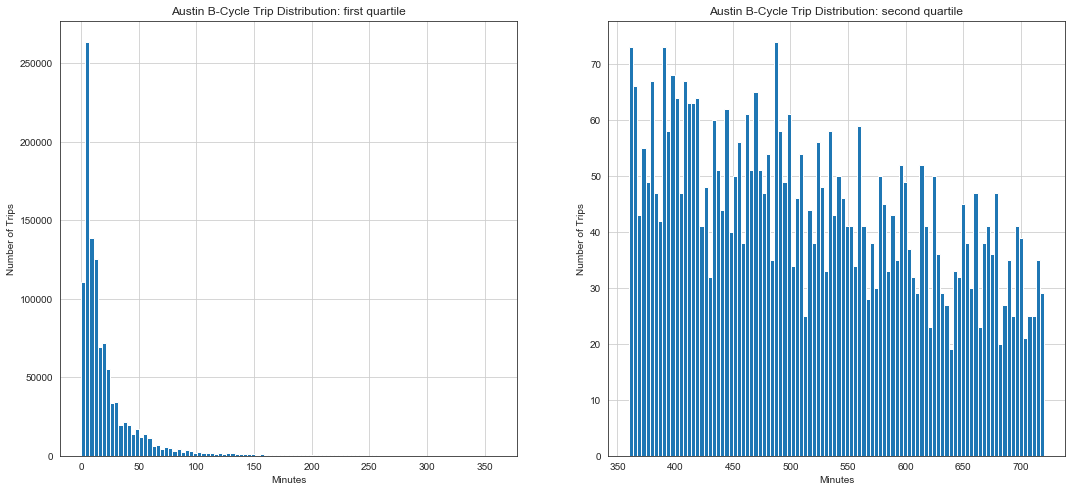

In [60]:

plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: first quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(0, 360))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
bcycle.trip_duration_minutes.hist(bins=100, range=(360, 720))
plt.title("Austin B-Cycle Trip Distribution: second quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")


plt.show()

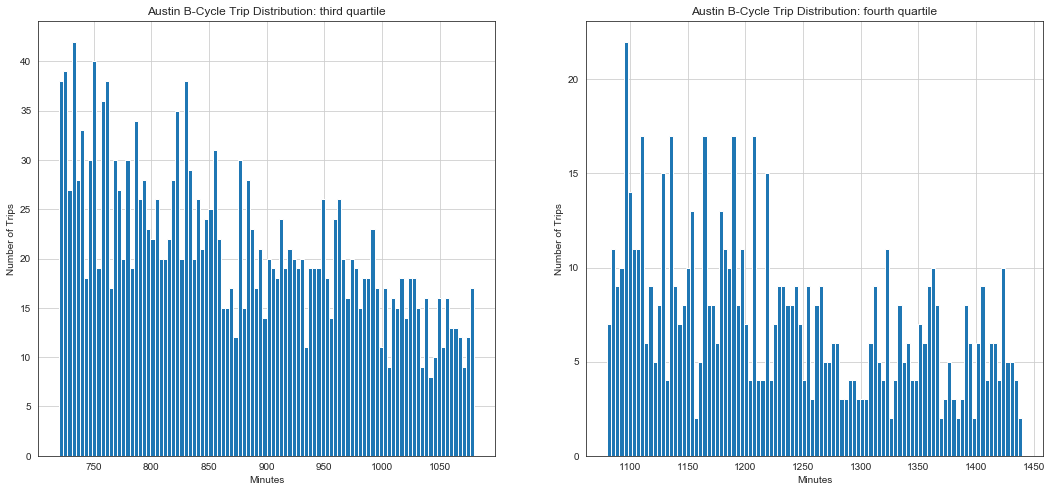

In [61]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: third quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(720, 1080))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: fourth quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(1080, 1440))
plt.show()

## We can determine now that what we can categorize as a Real Ride is no longer than 1,440 minutes. But does the floor start at zero?

# False starts

## Unlike the Dockless dataset, there does not appear to be a massive amount of rides that went nowhere. While we do not have the distance traveled to verify that, there are several rides that lasted 0, 1, or 2 minutes.

## Since rides lasting 1 or 2 minutes are less than the number of rides measured for 3 minute rides combined, I will mark 0-2 minute rides as False Starts. This can be adjusted in the future for modeling purposes.

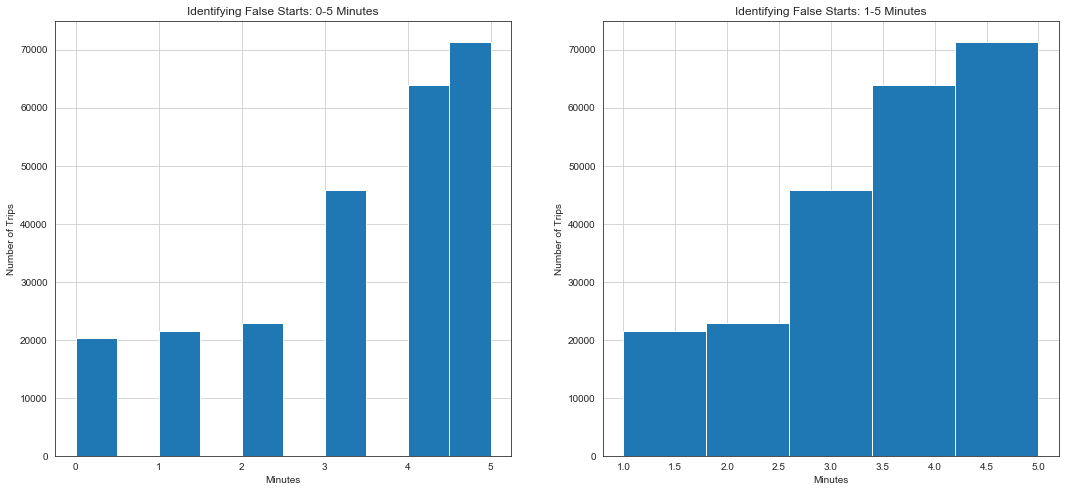

In [62]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
bcycle.trip_duration_minutes.hist(bins=10, range=(0, 5))
plt.title("Identifying False Starts: 0-5 Minutes")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")

plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
bcycle.trip_duration_minutes.hist(bins=5, range=(1, 5))
plt.title("Identifying False Starts: 1-5 Minutes")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
plt.show()

In [63]:
#bcycle = pd.read_pickle('./Austin_B-Cycle_Visualization.pkl')
#bcycle.to_pickle('./Austin_B-Cycle_Visualization.pkl')

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________


# SECTION II: PRIVATE SECTOR DOCKLESS BIKE & SCOOTER SERVICES

## Data Cleaning: Private Sector Dockless Bike & Scooter Services

## There are 5.44 millions dockless rides and a very small amount of rows with NaN's

In [64]:
#visual aid for the rows with NaN's
dockless.isnull().sum()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

In [65]:
# creating and printing the variable for the original number of rides in the dataset (including NaN's)
dockless_rides = len(dockless)
print(dockless_rides)

5441283


## How many unique rows have NaN's ?

In [66]:
# drop rows with NaN's
dockless = dockless.dropna(axis=0)

In [67]:
# confirmation all rows with NaN's are dropped
dockless.isnull().sum()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

In [68]:
# creating and printing the variable for the number of rides in the dataset without NaN's
dockless_no_nans = len(dockless)
print(dockless_no_nans)

5441283


## 99.99% of the rides in this dataset don't have NaN values so we can safely drop the rows with NaN's.

In [69]:
nan_dockless_percent = dockless_no_nans / dockless_rides
print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      .format(dockless_no_nans, dockless_rides, nan_dockless_percent))

There are 5441283 rides without NaN values out of 5441283 total rides, which is equal to 1.0.


# Cleaning up columns

In [70]:
# data clean columns: 
dockless.columns = dockless.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop the modified_date columnsince it is just the date that, according to the AustinTexas.gov website:
## "The [modified_date is when]...the record was last modified (typically the date the data was extracted/loaded from the data provider), in local time (US/Central)."

In [71]:
#dockless.drop(['modified_date'], axis=1, errors='coerce', inplace=True)

## Convert start/end time using to_datetime into a Unix timestamp

In [57]:
# create two new columns to convert the time values to unix
dockless['unix_start_time'] = dockless.start_time
dockless['unix_end_time'] = dockless.end_time

In [67]:
dockless.head(5)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type,vehicle_mask
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,2018.0,1543597200,1555088400,191526.72,0.00,1,1658,0,1
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,2019.0,1556533800,1556533800,2.83,0.00,1,0,1,0
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,2019.0,1556533800,1556533800,1.50,0.00,1,0,1,0
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570.0,826.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4.0,17.0,1.0,2019.0,1556532900,1556532900,9.50,1.45,1,826,0,0
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,2019.0,1556533800,1556534700,7.30,4.14,1,1815,0,0


In [59]:
from datetime import datetime
# set the parameter for how the date is being interpretted
merge_time_dock = datetime.strptime('04/29/2019 05:30:00 PM', '%m/%d/%Y %H:%M:%S %p')
type(merge_time_dock)
# how i want the time coverted to (seconds)
merge_time_dock.strftime('%s')
# define unix timestamp function
def dockless_to_timestamp(str):
    merge_time_dock = datetime.strptime(str, '%m/%d/%Y %H:%M:%S %p')
    return merge_time_dock.strftime('%s')

In [60]:
# apply timestamp to new unix start time
dockless['unix_start_time'] = dockless.unix_start_time.apply(dockless_to_timestamp)

In [61]:
# apply timestamp to new unix end time
dockless['unix_end_time'] = dockless.unix_end_time.apply(dockless_to_timestamp)

In [62]:
# convert to integer
dockless['unix_start_time'] = pd.to_numeric(dockless['unix_start_time'], errors='ignore', downcast='integer')

In [63]:
# convert to integer
dockless['unix_end_time'] = pd.to_numeric(dockless['unix_end_time'], errors='ignore', downcast='integer')

## Drop Council Districts

In [66]:
dockless.drop(['council_district_start', 'council_district_end'], 1, inplace=True)

## Memory adjustments

In [81]:
# memory calc for dockless data set
for dtype in ['float','int','object']:
    selected_dtype = dockless.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 359.79MB


In [82]:
dockless.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5441283 entries, 1 to 5442038
Data columns (total 16 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration_seconds     float64
trip_distance             float64
start_time                object
end_time                  object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
unix_start_time           int32
unix_end_time             int32
trip_duration_minutes     float64
dtypes: float64(9), int32(2), object(5)
memory usage: 2.5 GB


## For the most part, all the trips start and end in the same Council District, with the exception being zone Zero starting at 5th place but ending at 8th.

In [83]:
len(dockless)

5441283

In [84]:
#dockless['council_district_start'].value_counts()

In [85]:
#dockless['council_district_end'].value_counts()

## According to the maps, there are only 10 Council Districts yet there are 11 districts in the data.

In [86]:
#dockless.groupby('council_district_start').size()

In [87]:
#dockless.groupby('council_district_end').size()

## Since the zones 9,3,1, and 5 are either part of Downtown Austin or adjacent to it, it is safe to say that the Districts are ordered numerically and zone zero may be used as a substitute for NaN or an unknown.

In [88]:
#zone_zero_percent = dockless_no_nans / dockless_rides
#print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      #.format(dockless_no_nans, dockless_rides, nan_dockless_percent))

In [89]:
#keeps only rows without 0.0 (drops due to more advanced requirements)
#dockless = dockless[(dockless['council_district_start'] != 0.0) & (dockless['council_district_end'] != 0.0)]

In [90]:
#dockless_0_drop = len(dockless)
#print(dockless_0_drop)

In [91]:
# confirm new values
#dockless['council_district_start'].value_counts()

In [92]:
# confirm new values
#dockless['council_district_end'].value_counts()

## Even without those rows, we only dropped 1.04% of the original dataframe

In [93]:
#dockless_0_percent = dockless_0_drop / dockless_rides
#dockless_0_minus = (1-dockless_0_percent)
#print("Even after dropping all the rows with 0.0, we still have {}% of the original dataframe, or just a {}% loss"
      #.format(dockless_0_percent, dockless_0_minus))

## Converting ID and Device_ID for consistency

In [94]:
dockless['id']= dockless['id'].astype(str)

In [95]:
dockless['device_id']= dockless['device_id'].astype(str)

## Convert columns to integers

In [72]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,2018.0,1543597200,1555088400,191526.72,0.0,1,1658,0


In [73]:
dockless['trip_duration_seconds'] = pd.to_numeric(dockless['trip_duration_seconds'], errors='ignore', downcast='integer')

In [74]:
dockless['trip_distance'] = pd.to_numeric(dockless['trip_distance'], errors='ignore', downcast='integer')

In [75]:
dockless['month'] = pd.to_numeric(dockless['month'], errors='ignore', downcast='integer')

In [76]:
dockless['hour'] = pd.to_numeric(dockless['hour'], errors='ignore', downcast='integer')

In [77]:
dockless['day_of_week'] = pd.to_numeric(dockless['day_of_week'], errors='ignore', downcast='integer')

In [78]:
#dockless['council_district_start'] = pd.to_numeric(dockless['council_district_start'], errors='ignore', downcast='integer')

In [79]:
#dockless['council_district_end'] = pd.to_numeric(dockless['council_district_end'], errors='ignore', downcast='integer')

In [80]:
dockless['year'] = pd.to_numeric(dockless['year'], errors='ignore', downcast='integer')

In [82]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration_seconds      int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
year                       int16
unix_start_time            int32
unix_end_time              int32
trip_duration_minutes    float64
avg_speed                float32
device_id_trip_count       int16
odometer                   int64
trip_type                   int8
dtype: object

## Census GEOID cleanup

In [106]:
#dockless['census_tract_end'] = dockless.census_tract_end.astype(float)

In [107]:
#dockless['census_tract_start'] = dockless.census_tract_end.astype(float)

In [108]:
#dockless['census_tract_start'] = pd.to_numeric(dockless['census_tract_start'], errors='ignore', downcast='integer')

In [109]:
#dockless['census_tract_end'] = pd.to_numeric(dockless['census_tract_end'], errors='ignore', downcast='integer')

## Vehicle type analysis and conversion to get_dummies

## ~95% of all dockless vehicle rides are Scooters

In [110]:
dockless.vehicle_type.value_counts(1)

scooter    0.951486
bicycle    0.048514
Name: vehicle_type, dtype: float64

## Drop GEO-ID columns

In [111]:
#dockless.drop(['census_tract_start'], axis=1, errors='coerce', inplace=True)

In [112]:
#dockless.drop(['census_tract_end'], axis=1, errors='coerce', inplace=True)

## Create a column so time values are consistent in minutes and secondsmin both datasets

In [113]:
dockless.rename(columns={'trip_duration':'trip_duration_seconds'}, inplace=True)

In [114]:
dockless['trip_duration_minutes'] = round((dockless['trip_duration_seconds'] / 60), 2)

In [115]:
#dockless = dockless[['id', 'device_id', 'vehicle_type', 'trip_duration_minutes','trip_duration_seconds',
                   # 'trip_distance', 'start_time', 'end_time', 'month', 'hour', 'day_of_week',
                   # 'council_district_start', 'council_district_end', 'year']]

## I have a lot of negative values that are affecting the distribution

## Negative time

In [116]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

In [117]:
indices = dockless[dockless['trip_duration_seconds']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [118]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

## negative distance

In [119]:
dockless[dockless['trip_distance']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

In [120]:
indices = dockless[dockless['trip_distance']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [121]:
dockless[dockless['trip_distance']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
unix_start_time           0
unix_end_time             0
trip_duration_minutes     0
dtype: int64

## Creating formula for avg scooter distance

In [122]:
dockless.sample(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes
2909266,28121dbf-cc42-4bf9-af77-045d814211af,aa177c72-627a-47eb-84ad-a41adebf5853,scooter,1270,172,09/02/2018 12:30:00 PM,09/02/2018 12:45:00 PM,9,12,0,3.0,3.0,2018,1535909400,1535910300,21.17


In [123]:
# convert meters to miles
# https://www.metric-conversions.org/length/meters-to-miles.htm
to_miles = 0.00062137

## Listing the different scooter & bike manufacturers with their respectives ranges based on one full battery charge

In [124]:
# different manufactured types of scooters or bike w/ their ranges in miles based on one full battery charge
xiaomi = 15
jump_bike = 40
lime_s = 37
vespa = 50
veo_bike = 68

## List of all dockless companies with permits and ranges calculated

In [125]:
# Bird permits and scooter range
bird_permits_scooter = 1000
bird_range_scooter = xiaomi 

In [126]:
# JUMP permits and scooter/bike ranges
jump_permits_scooter = 500
jump_permits_bike = 500

jump_range_scooter = xiaomi 
jump_range_bike = jump_bike 

In [127]:
# Lime scooter permits and range
lime_permits_scooter = 500
lime_range_scooter = lime_s 

In [128]:
# Lyft scooter permits and range
lyft_permits_scooter = 500
lyft_range_scooter = xiaomi

In [129]:
# OjO scooter permits and range
ojo_permits_scooter = 100
ojo_range_scooter = vespa 

In [130]:
# Skip scooter permits and range
skip_permits_scooter = 500
skip_range_scooter = vespa 

In [131]:
# Spin scooter permits and range
spin_permits_scooter = 500
skip_range_scooter = xiaomi

In [132]:
# VeoRide scooter & bike permits and range
veo_permits_scooter = 300
veo_permits_bike = 50

veo_range_scooter = xiaomi 
veo_range_bike = veo_bike

pap8 - stipulate how code should look (4 tabs, etc)
all code < 80 characters

## Permit Totals

In [133]:
# formula for scooter permits
total_scooter_permits = (bird_permits_scooter + 
                         jump_permits_scooter + 
                         lime_permits_scooter + 
                         lyft_permits_scooter +
                         ojo_permits_scooter +
                         skip_permits_scooter + 
                         spin_permits_scooter + 
                         veo_permits_scooter)
print(total_scooter_permits)

3900


In [134]:
#formula for bike permits
total_bike_permits = (jump_permits_bike + veo_permits_bike)
print(total_bike_permits)

550


## Permit Percentages

In [135]:
# formulas for scooter weighted avg
bird_s_pct = bird_permits_scooter / total_scooter_permits
jump_s_pct = jump_permits_scooter / total_scooter_permits
lime_s_pct = lime_permits_scooter / total_scooter_permits
lyft_s_pct = lyft_permits_scooter / total_scooter_permits
ojo_s_pct = ojo_permits_scooter / total_scooter_permits
skip_s_pct = skip_permits_scooter / total_scooter_permits
spin_s_pct = spin_permits_scooter / total_scooter_permits
veo_s_pct = veo_permits_scooter / total_scooter_permits

In [136]:
# formulas for bike weighted avg
jump_b_pct = jump_permits_bike / total_bike_permits
veo_b_pct = veo_permits_bike / total_bike_permits
print(jump_b_pct)
print(veo_b_pct)

0.9090909090909091
0.09090909090909091


In [137]:
permit_totals = [bird_permits_scooter, jump_permits_scooter, lime_permits_scooter, lyft_permits_scooter,
                        ojo_permits_scooter, skip_permits_scooter, spin_permits_scooter, veo_permits_scooter]

for permit in permit_totals:
    print(permit / total_scooter_permits)

0.2564102564102564
0.1282051282051282
0.1282051282051282
0.1282051282051282
0.02564102564102564
0.1282051282051282
0.1282051282051282
0.07692307692307693


## Pickling Dockless

In [140]:
#dockless.to_csv('dockless_cleaned')

#dockless = pd.read_pickle('./Dockless_Vehicle_Trips.pkl')
#dockless.to_pickle('./Dockless_Vehicle_Trips_cleaned.pkl')

# Section II: Data Visualization & Exploration

## One issue we have with the Bcycle dataset is that while we do know the specific start and end location of each ride, we don't know know the actual distance. 
## In the Dockless dataset we have the opposite problem: we have an accurate distance traveled but no location specific information with the start and end locations to preserve anonymity. While we can't use the distance, we will use the ride duration as a proxy.

## Dockless trip_distance distributions

In [148]:
# creating a new variable to capture the shortened distribution
df_distance = dockless.loc[(dockless['trip_distance'] <= 15373.8)]
len(df_distance)

5436359

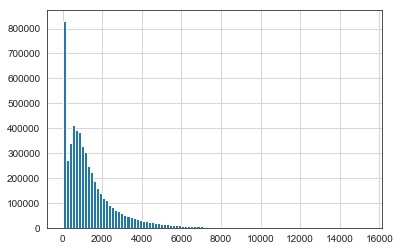

In [149]:
df_distance.trip_distance.hist(bins=100)

## Outliers were affecting the distributions after ~8,000 meters (4.87 miles) so we narrowed the rides we observed to see the long tail more accurately at a max of 15,383.8 meters

## Limiting to 15,373.8 meters kept 99.9% of the ride data for analysis

In [150]:
# division of new variable up to 15,373.8 m divided by the total number of rides in the dataset
len(df_distance) / len(dockless)

0.9990950663657817

 # Furthermore, <1% of the rides extend beyond 8000 meters (4.87 mi)

In [151]:
dockless.loc[(dockless['trip_distance'] >= 8000)].count()

id                        51309
device_id                 51309
vehicle_type              51309
trip_duration_seconds     51309
trip_distance             51309
start_time                51309
end_time                  51309
month                     51309
hour                      51309
day_of_week               51309
council_district_start    51309
council_district_end      51309
year                      51309
unix_start_time           51309
unix_end_time             51309
trip_duration_minutes     51309
dtype: int64

In [152]:
49854 / len(df_distance)

0.009170476048399306

## There is a high occurence of what appears to be "false starts," so I explored where a single value or a range is responsible

# Starting from range 100-8000 eliminated the clustered data

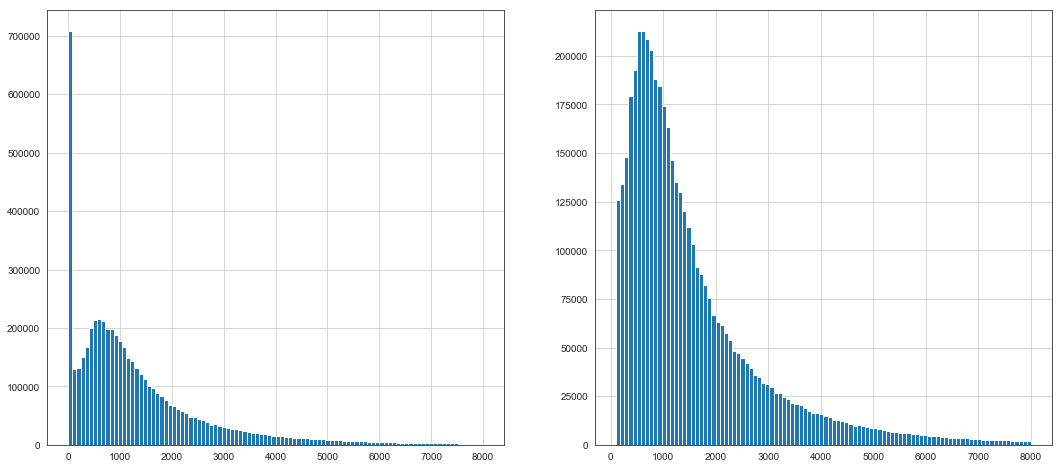

In [153]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(0,8000))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(100,8000))
plt.show()

## 1-100 and 1-10 was not as helpful as I expected

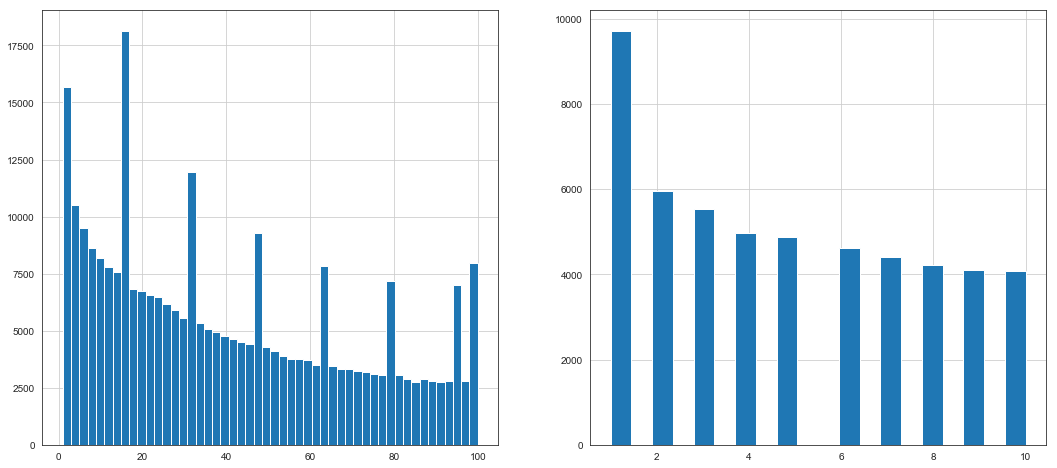

In [154]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,100))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(1,10))

## However, it is clear that the bunched up values are not a range but rather just zero

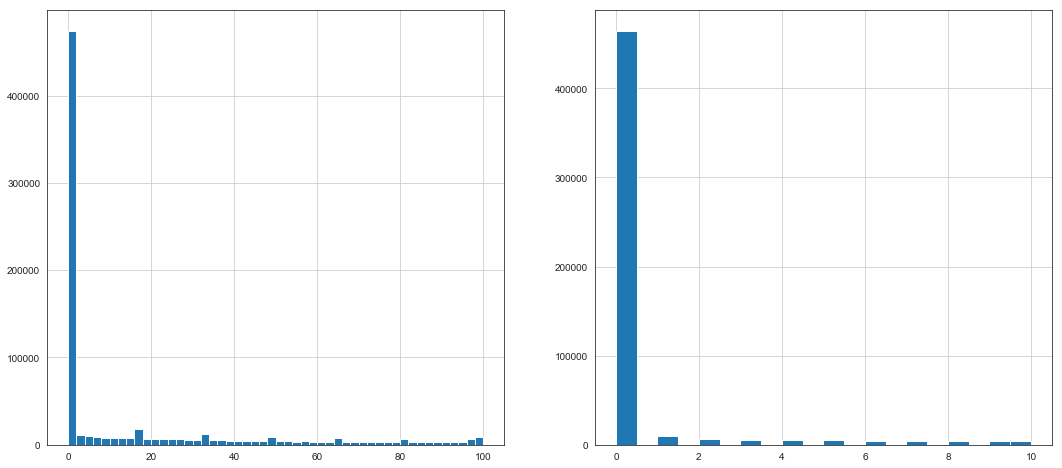

In [155]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(0,100))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(0,10))

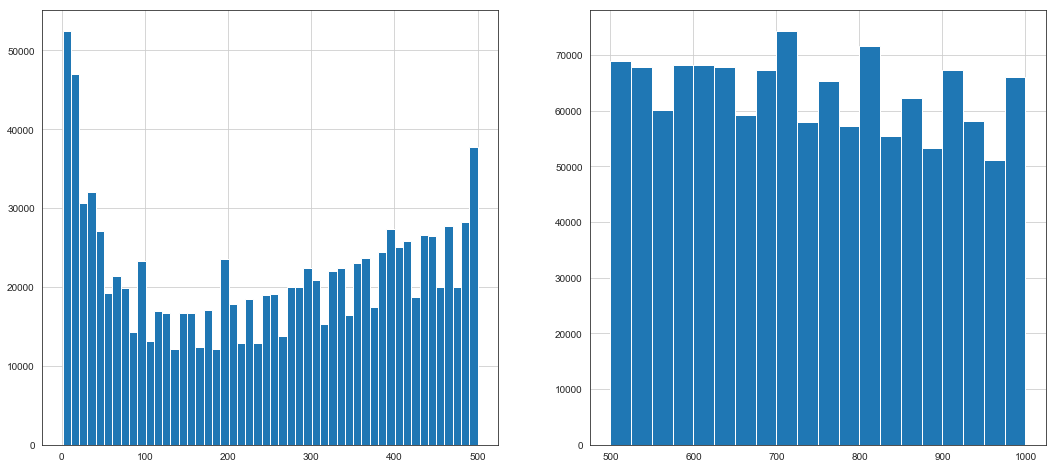

In [156]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,500))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(500,1000))

## I need to recreate a variable that removes both false starts (trip distance >1 m) and outliers (>16000 meters)

In [6]:
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] > 1) & (dockless['trip_distance'] <= 16000)]
len(normal_dockless_rides)

4962659

## ~91% of the rides are considered within this range

In [158]:
rr = len(normal_dockless_rides) / len(dockless)
rr

0.9120383924159063

In [159]:
false_rides = dockless.loc[(dockless['trip_distance'] < 1)]
len(false_rides)

464633

In [160]:
fr = len(false_rides) / len(dockless)
fr

0.08539033900644388

In [161]:
(rr - fr) / 100

0.008266480534094624

## While clear, the scooter data's range (which is ~95% of the original data) is hiding the distribution of the bike data.

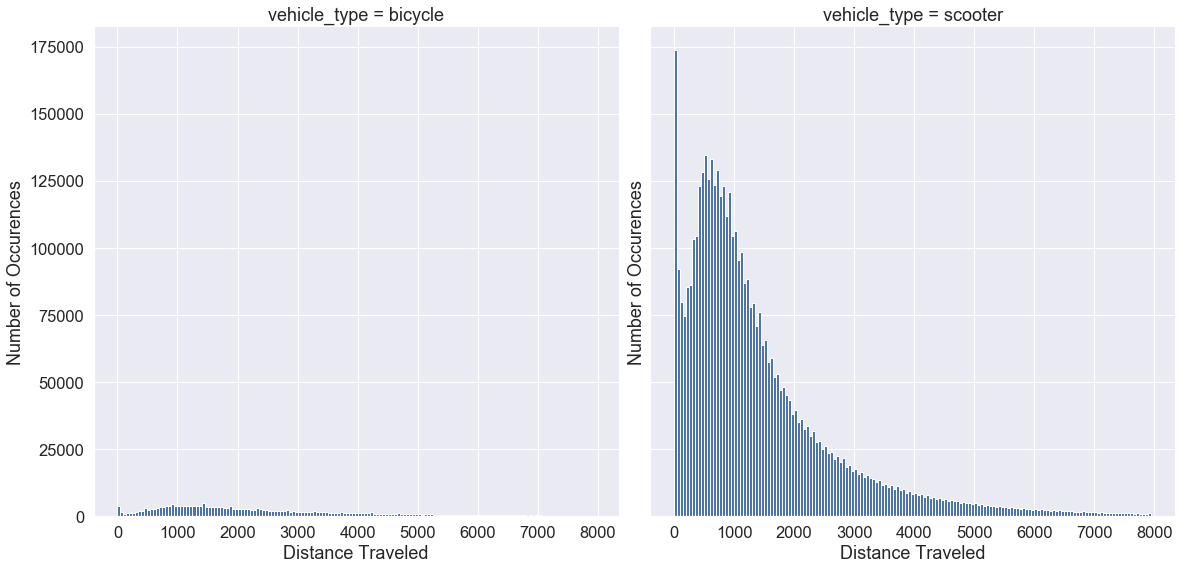

In [162]:
sns.set_style("whitegrid")
sns.set_palette("BuGn_r")
sns.set(font_scale=1.5) 

bins = np.arange(0, 8000, 50)
dockless_types = sns.FacetGrid(normal_dockless_rides, col='vehicle_type', height=8.27)
dockless_types.map(plt.hist, "trip_distance", bins=bins)
dockless_types.set(xlabel='Distance Traveled', ylabel='Number of Occurences')

## I created a new dataframe for only real dockless scooters and bikes where the trip duration and distance was >= 1

In [163]:
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]


In [164]:
normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [165]:
normal_dockless_rides_s.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570.0,826.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,9.5


In [166]:
normal_dockless_rides_b.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72


## It appears that while both have similar distribution shapes, the bike rides tend to cover longer distances

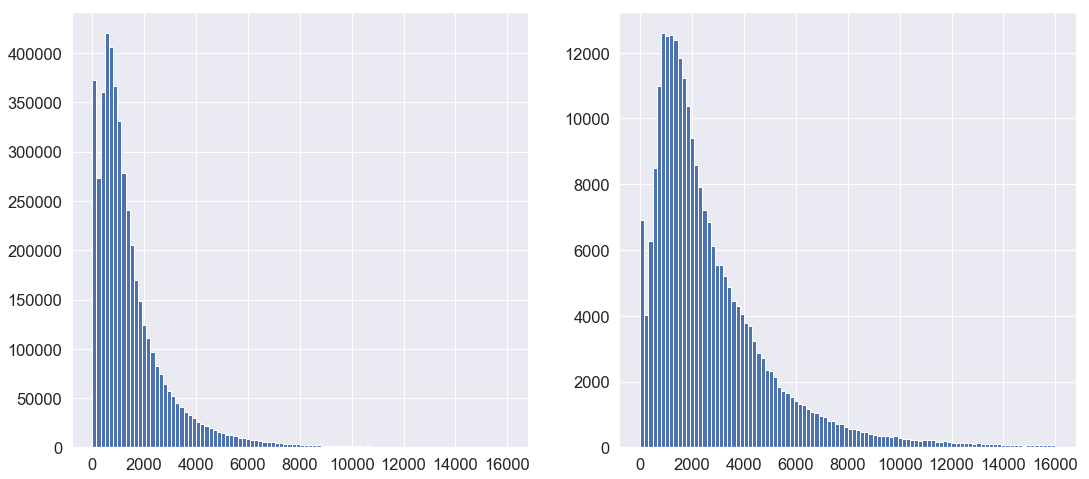

In [167]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
normal_dockless_rides_s.trip_distance.hist(bins=100)
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
normal_dockless_rides_b.trip_distance.hist(bins=100)
plt.show()

## Day of Week analysis

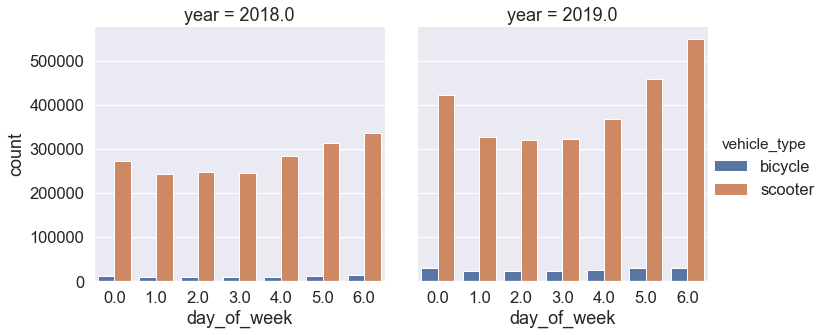

In [168]:
sns.catplot(x="day_of_week", hue="vehicle_type", col='year', 
            data=normal_dockless_rides, kind='count')

## Even though the data from 2019 has three fewer months worth compared to 2018, there is about  ~50% more data which speaks to the increased adoption rate in the city.

In [169]:
count_2018 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2018)])
count_2019 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2019)])

print("The total number of real rides in 2018 was {}.".format(count_2018))
print("The total number of real rides in 2019 was {}.".format(count_2019))

The total number of real rides in 2018 was 2015193.
The total number of real rides in 2019 was 2947466.


## Now that we have a better idea of the trip distance distribution as a whole, what about the individual dockless scooters & bikes themselves? What can the unique devices tell us about all these rides

## The most used scooter was riden 693 times

In [170]:
# created a new variable for how frequently unique devices were used
device_freq = dockless.device_id.value_counts()
device_freq

e9de6733-842d-46c6-bdec-2b1bb3ce6e78    693
c501eef0-c361-4c25-9489-acaff8a3eeeb    679
6cb1120f-282a-4894-89e7-395a13b1f1d0    647
460665fe-f0b7-4fb8-a537-50b5e33cf066    640
fa8de131-5904-4daa-8483-52ab9fea3e86    635
45b01aae-956f-43dc-8e19-41e8bf8ff751    634
c5a230c9-7e80-4464-862f-f2b23f61d6d3    629
d6f2fc5a-3d0e-468f-9877-f058e711a36a    625
b114da11-7a03-4fbc-a0ae-99c7bc62d3cc    624
a4b4b5f3-146a-44c3-bfe2-5cced39ac109    618
62c3da38-3838-45c2-be6d-f579b65daf11    617
8cdc86b5-3a01-4655-a580-0a02e9d05b5b    614
5e4baa97-2064-4392-8aff-d0d129561cf4    613
66b3ee16-b8b0-45b0-82de-393e1d12016f    613
a3252fef-c4ce-4de9-a446-c23495f720c8    612
                                       ... 
1d88f691-27b2-468d-8a8a-7a2ef7d7846e      1
aa24c34d-7466-469a-a9bf-f2a91cc5698e      1
1251d411-8de4-4d54-9f0a-4c8e32e4a70c      1
a5110d50-7338-4a02-a588-5746adf1ed14      1
c4da8575-f7c0-4689-b4e9-17c591a46e44      1
e4566a21-cd7a-4668-a397-8da29e29eef3      1
771ec687-f28c-4d4c-9bb1-606d5e95

## Similar to the distance distribution, we also have a long tail with how heavily used scooters are used.

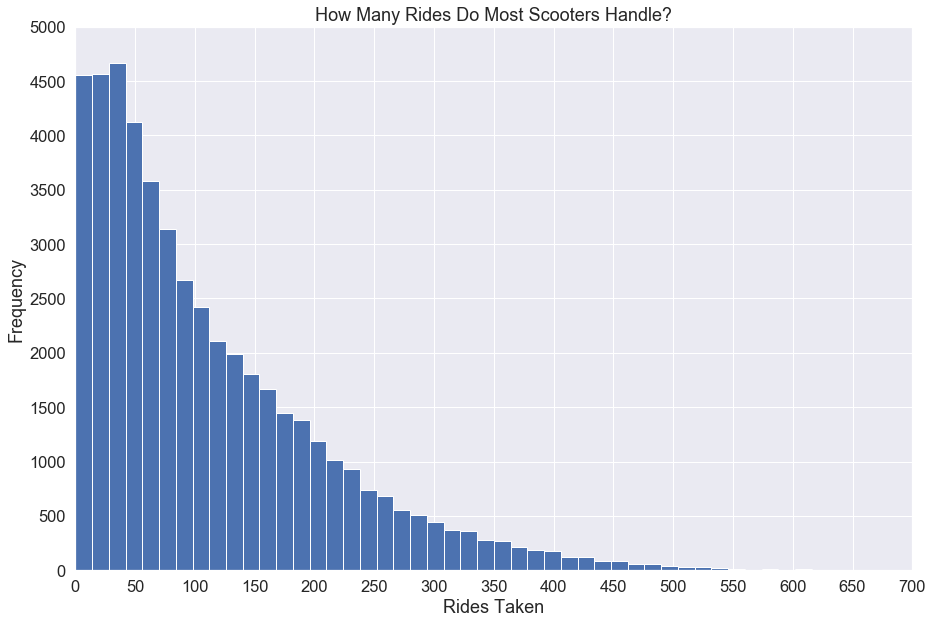

In [171]:
# The full distribution

plt.figure(figsize=[15, 10])
d_id_plot = device_freq.hist(bins=50, range=(0, 700))
plt.title('How Many Rides Do Most Scooters Handle?')
plt.xlabel('Rides Taken')
plt.ylabel('Frequency')
unique_devices = d_id_plot.set(xlim=(0,700),
                ylim=(0,5000),
                xticks=[0,50, 100, 150, 200, 250, 300, 350,
                        400, 450, 500, 550, 600, 650, 700],
                yticks=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500,
                        4000, 4500, 5000])


## The tail is a bit extended and not as smooth as the distance distribution. Perhaps this rigid curve has something to do with the individual scooters themselves?

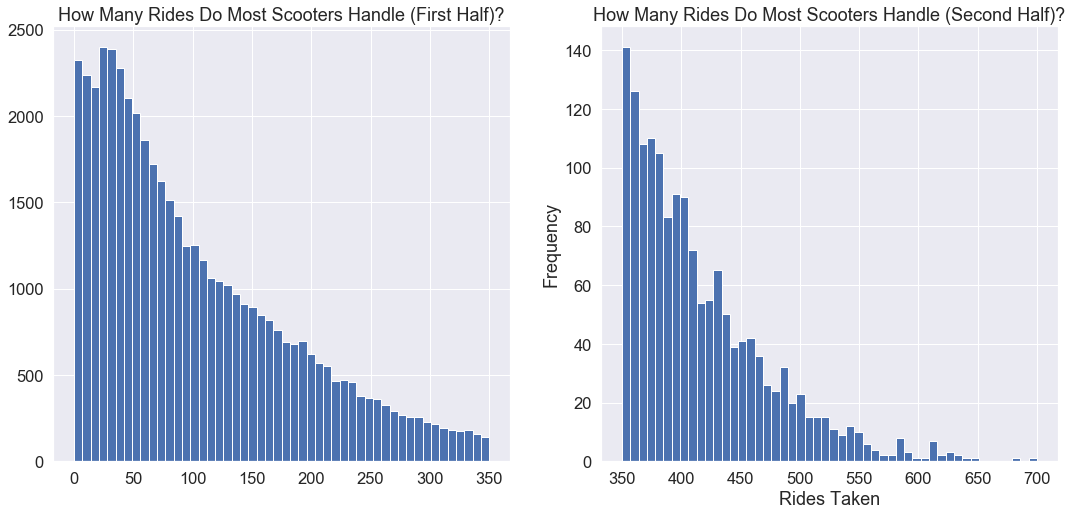

In [172]:
#The distribution cut in half
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
d_id_ax1 = device_freq.hist(bins=50, range=(0, 350))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
d_id_ax2 = device_freq.hist(bins=50, range=(350, 700))

plt.xlabel('Rides Taken')
plt.ylabel('Frequency')
d_id_ax1.title.set_text('How Many Rides Do Most Scooters Handle (First Half)?')
d_id_ax2.title.set_text('How Many Rides Do Most Scooters Handle (Second Half)?')


plt.show()

## So how many scooters had a false start?

In [173]:
mask_false_start = dockless.trip_distance == 0

In [174]:
mask_scooter = dockless.vehicle_type == 'scooter'

In [175]:
mask_bike = dockless.vehicle_type == 'bicycle'

In [176]:
dockless_false_start_s = dockless[mask_false_start & mask_scooter] 

In [177]:
dockless_false_start_b = dockless[mask_false_start & mask_bike] 

In [178]:
mask_false_start.sum()

464633

In [179]:
mask_scooter.sum()

5177304

In [180]:
mask_bike.sum()

263979

In [181]:
(mask_scooter & mask_bike).sum()

0

## Number of False Starts

In [182]:
(mask_scooter & mask_false_start).sum()

455094

In [183]:
(mask_bike & mask_false_start).sum()

9539

In [184]:
#dockless = pd.read_pickle('./Dockless_Vehicle_Trips.pkl')
#dockless.to_pickle('./Dockless_Vehicle_Trips.pkl')

# Section III: Feature Engineering

## To unify the two datasets, I need to create a feature for:
## 1. The average speed for scooters and bikes in the dockless dataset so I can calculate the distance traveled in the bcycle dataset. Unfortunately, the bcycle dataset only provides trip duration with the start and end location. While imperfect, this will give me a best available estimate (distance = speed X time).
## 2. The number of trips 
## 3. An odometer for each unique scooter than updates with each ride.
## 4. A Classifier for whether a ride is a false start or not; for dockless it is =0 and in Bcycle it is = to 0-2 
## 5. Downcast new features 
## 6. New Bcycle Time feature

## This will also help with my pairplots and heatmaps to bettter view relationships.

## 1. Creating Average Speed Feature

In [185]:
# speed = distance / time. Creating a new column for avg speed.
dockless['avg_speed'] = round((dockless['trip_distance'] / dockless['trip_duration_seconds']), 2)

In [39]:
#Calling the varaible again to no include the new 'avg_speed' column
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [187]:

#Calling the varaible again to no include the new 'avg_speed' column
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]

normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 16000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [188]:
normal_dockless_rides_s.head(5)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570.0,826.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,9.50,1.45
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,7.30,4.14
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,391.0,1519.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,6.52,3.88
8,1c8b3eab-6aed-4b69-8eca-6b5e0b70a45f,ab262134-2421-49b7-a97f-fadde23e71db,scooter,570.0,1843.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,9.50,3.23
9,f9174176-9d16-431d-af21-ebcab226da31,73e8b0bf-3aae-4f80-8683-c5d7c3b3989a,scooter,668.0,2829.0,04/29/2019 05:15:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:15:00 PM,04/29/2019 05:30:00 PM,11.13,4.24


## Scooter mean & median, meters / second

In [189]:
# mean
normal_dockless_rides_s['avg_speed'].mean()

2.48725015034279

In [190]:
# median
normal_dockless_rides_s['avg_speed'].median()

2.39

## Bike mean & median, meters / second

In [191]:
# mean
normal_dockless_rides_b['avg_speed'].mean()

3.360445016652103

In [192]:
# median
normal_dockless_rides_b['avg_speed'].median()

3.32

In [193]:
# saving this variable to use in Bcycle; meters / second
avg_bike_speed = normal_dockless_rides_b['avg_speed'].mean()

## Since we don't have a column with distance information in BCycle, we will use the average speed we found in Dockless to understand the distance these bikes may have taken.
## Applying Trip_Distance using our new bike speed 

In [194]:
# distance = speed x time; rounding up to conserve space
bcycle['trip_distance'] = round((avg_bike_speed * bcycle.trip_duration_seconds), 2)

In [195]:
bcycle.trip_distance.head(3)

0    15323.63
1    11694.35
2     1613.01
Name: trip_distance, dtype: float64

## 2. The number of trips per unique device

In [196]:
# new variable to measure length of dataset
device_id_set_length_dock = len(set(dockless['device_id']))

# Dictionary to store cumulative counts
device_id_dict_dock = dict(zip(set(dockless['device_id']), np.zeros(device_id_set_length_dock)))

# Empty list to store running count
running_count_dock = []

# Loop through all values
for row in dockless.itertuples():
  device_id_dict_dock[row[2]] += 1
  running_count_dock.append(device_id_dict_dock[row[2]])
  
dockless['device_id_trip_count'] = running_count_dock

In [197]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72,0.0,1.0


## Let's see if it is successfully counting by searching for a specific ID...and it is!

In [198]:
dockless.loc[dockless.device_id == '746fbee1-3a56-4275-8f0f-b36862d1bb53']

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count
31586,4290a0f9-4c21-483a-a130-3914a960b6f3,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,688.0,1325.0,04/06/2019 07:15:00 PM,04/06/2019 07:30:00 PM,4.0,19.0,6.0,9.0,1.0,2019.0,04/06/2019 07:15:00 PM,04/06/2019 07:30:00 PM,11.47,1.93,1.0
2121437,6c6883c8-6f25-4436-8b17-abf73011e939,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,205.0,692.0,03/11/2019 04:45:00 PM,03/11/2019 04:45:00 PM,3.0,16.0,1.0,9.0,9.0,2019.0,03/11/2019 04:45:00 PM,03/11/2019 04:45:00 PM,3.42,3.38,2.0
2124150,4c89f32a-2f22-48e3-828a-e7cc1e16b636,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,514.0,2100.0,12/27/2018 04:15:00 PM,12/27/2018 04:15:00 PM,12.0,16.0,4.0,3.0,3.0,2018.0,12/27/2018 04:15:00 PM,12/27/2018 04:15:00 PM,8.57,4.09,3.0
2126497,48d5b3c2-4a0b-4602-a586-afed48a06402,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,1133.0,1900.0,10/10/2018 06:00:00 PM,10/10/2018 06:15:00 PM,10.0,18.0,3.0,0.0,1.0,2018.0,10/10/2018 06:00:00 PM,10/10/2018 06:15:00 PM,18.88,1.68,4.0
2134238,2e919792-d0ab-47fe-9037-8a035db3edf2,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,764.0,2782.0,03/09/2019 10:00:00 PM,03/09/2019 10:15:00 PM,3.0,22.0,6.0,3.0,9.0,2019.0,03/09/2019 10:00:00 PM,03/09/2019 10:15:00 PM,12.73,3.64,5.0
2134999,7f2dd0a6-7511-4058-8412-af4cc72a7e63,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,129.0,138.0,03/09/2019 03:45:00 PM,03/09/2019 03:45:00 PM,3.0,15.0,6.0,9.0,9.0,2019.0,03/09/2019 03:45:00 PM,03/09/2019 03:45:00 PM,2.15,1.07,6.0
2135081,f0f85ff5-0706-44bc-8497-ae35a1e01af1,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,2241.0,517.0,03/09/2019 07:00:00 PM,03/09/2019 07:30:00 PM,3.0,19.0,6.0,9.0,9.0,2019.0,03/09/2019 07:00:00 PM,03/09/2019 07:30:00 PM,37.35,0.23,7.0
2136096,bf082e57-d5ae-4d46-9b8b-0108662aca72,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,2070.0,6093.0,03/29/2019 06:00:00 PM,03/29/2019 06:30:00 PM,3.0,18.0,5.0,9.0,1.0,2019.0,03/29/2019 06:00:00 PM,03/29/2019 06:30:00 PM,34.50,2.94,8.0
2147911,bb1e77c9-52f4-4ac3-9ed6-8c5008c67245,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,145.0,213.0,03/09/2019 06:00:00 PM,03/09/2019 06:00:00 PM,3.0,18.0,6.0,9.0,9.0,2019.0,03/09/2019 06:00:00 PM,03/09/2019 06:00:00 PM,2.42,1.47,9.0
2149215,e43dd1e1-65a2-49bc-8d2e-163f457ac98a,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,1695.0,1500.0,10/31/2018 03:45:00 PM,10/31/2018 04:15:00 PM,10.0,15.0,3.0,1.0,1.0,2018.0,10/31/2018 03:45:00 PM,10/31/2018 04:15:00 PM,28.25,0.88,10.0


## Now we will do the same in the BCycle data set

In [199]:
# new variable to measure length of dataset
device_id_set_length_bcycle = len(set(bcycle['bicycle_id']))

# Dictionary to store cumulative counts
device_id_dict_bcycle = dict(zip(set(bcycle['bicycle_id']), np.zeros(device_id_set_length_bcycle)))

# Empty list to store running count
running_count_bcycle = []

# Loop through all values; the row has to be changed to 3 to count the bicycle_id column
for row in bcycle.itertuples():
  device_id_dict_bcycle[row[3]] += 1
  running_count_bcycle.append(device_id_dict_bcycle[row[3]])
  
bcycle['device_trip_count'] = running_count_bcycle

## Verified that it is counting trips

In [200]:
bcycle.loc[bcycle.bicycle_id == 969]

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480,1414347120,13,10,2014,0,11694.35,1.0
598,9900286446,Semester Membership (Austin B-cycle),969,2495,4th & Congress,2552,3rd & West,3,180,1414433520,13,10,2014,1,604.88,2.0
606,9900286454,Semester Membership (Austin B-cycle),969,2552,3rd & West,2495,4th & Congress,0,0,1414433520,13,10,2014,1,0.00,3.0
761,9900286609,Semester Membership (Austin B-cycle),969,2495,4th & Congress,2567,Palmer Auditorium,8,480,1414447920,17,10,2014,1,1613.01,4.0
900,9900286746,24-Hour Kiosk (Austin B-cycle),969,2567,Palmer Auditorium,2503,South Congress & James,10,600,1414476720,01,10,2014,2,2016.27,5.0
2117,9900287946,Annual Membership (Austin B-cycle),969,2499,City Hall / Lavaca & 2nd,2712,Toomey Rd @ South Lamar,9,540,1414707120,17,10,2014,4,1814.64,6.0
2180,9900288008,24-Hour Kiosk (Austin B-cycle),969,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,82,4920,1414714320,19,10,2014,4,16533.39,7.0
2233,9900288060,24-Hour Kiosk (Austin B-cycle),969,2712,Toomey Rd @ South Lamar,2495,4th & Congress,11,660,1414757520,07,10,2014,5,2217.89,8.0
2485,9900288305,24-Hour Kiosk (Austin B-cycle),969,2550,Republic Square @ Guadalupe & 4th St.,2572,Barton Springs Pool,24,1440,1414782720,14,10,2014,5,4839.04,9.0
2585,9900288403,24-Hour Kiosk (Austin B-cycle),969,2572,Barton Springs Pool,2552,3rd & West,15,900,1414789920,16,10,2014,5,3024.40,10.0


## 3. The odometer per unique device

## Testing the odometer on a single device_id

In [201]:
odometer_test1 = dockless[dockless.device_id == '6b90a827-60a1-47ad-94a4-d33654dbd50d']

In [202]:
test_odo = odometer_test1.trip_distance.cumsum()

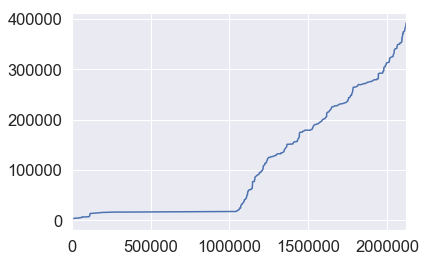

In [203]:
test_odo.plot()

## Making the Odometer on a large scale

In [204]:
dockless['odometer'] = dockless.groupby('device_id')['trip_distance'].transform(pd.Series.cumsum)

## Verified that it works using a random device_id

In [205]:
dockless.loc[dockless.device_id == '1e5234a3-e86b-41e1-a1ad-e98310f3a71c']

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,1.50,0.00,1.0,0.0
96,e0ea4c37-91c1-4e57-9393-1dd5b72e2f78,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,348.0,1183.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,5.80,3.40,2.0,1183.0
598,d7ee689e-bfe2-4d38-8ef4-f75984493305,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,403.0,1173.0,04/29/2019 05:45:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:45:00 PM,04/29/2019 05:45:00 PM,6.72,2.91,3.0,2356.0
883,c9b6872a-a8cd-4fb2-bf93-ec137130fc40,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,830.0,1851.0,05/10/2019 07:15:00 PM,05/10/2019 07:30:00 PM,5.0,19.0,5.0,9.0,3.0,2019.0,05/10/2019 07:15:00 PM,05/10/2019 07:30:00 PM,13.83,2.23,4.0,4207.0
8214,0fffd64c-5e46-4fac-a49c-3b5392c3260d,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,410.0,1193.0,05/26/2019 12:00:00 AM,05/26/2019 12:00:00 AM,5.0,0.0,0.0,9.0,9.0,2019.0,05/26/2019 12:00:00 AM,05/26/2019 12:00:00 AM,6.83,2.91,5.0,5400.0
17112,c3b37a52-fe0e-402c-bf60-e1fd9615f7af,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,340.0,1667.0,04/12/2019 04:00:00 PM,04/12/2019 04:00:00 PM,4.0,16.0,5.0,3.0,9.0,2019.0,04/12/2019 04:00:00 PM,04/12/2019 04:00:00 PM,5.67,4.90,6.0,7067.0
17181,3251782f-690a-4446-b767-8a6ece84a6dd,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,302.0,1102.0,05/02/2019 11:15:00 PM,05/02/2019 11:15:00 PM,5.0,23.0,4.0,3.0,3.0,2019.0,05/02/2019 11:15:00 PM,05/02/2019 11:15:00 PM,5.03,3.65,7.0,8169.0
18714,c47f1787-ccaa-45f0-b253-011010656259,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,302.0,739.0,04/27/2019 11:15:00 PM,04/27/2019 11:15:00 PM,4.0,23.0,6.0,9.0,9.0,2019.0,04/27/2019 11:15:00 PM,04/27/2019 11:15:00 PM,5.03,2.45,8.0,8908.0
20310,649ef453-43e1-4d11-807c-cc3c5ccb068a,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,274.0,793.0,04/30/2019 01:45:00 AM,04/30/2019 01:45:00 AM,4.0,1.0,2.0,9.0,9.0,2019.0,04/30/2019 01:45:00 AM,04/30/2019 01:45:00 AM,4.57,2.89,9.0,9701.0
37754,a38455ae-1f56-45b8-a0d8-54bc715217f2,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,369.0,1085.0,05/02/2019 10:45:00 PM,05/02/2019 11:00:00 PM,5.0,22.0,4.0,3.0,3.0,2019.0,05/02/2019 10:45:00 PM,05/02/2019 11:00:00 PM,6.15,2.94,10.0,10786.0


## Now I'll do the same for the Bcycle dataset

In [206]:
# odometer
bcycle['odometer'] = bcycle.groupby('bicycle_id')['trip_distance'].transform(pd.Series.cumsum)

In [207]:
# verify the odometer works
bcycle.loc[bcycle.bicycle_id == 207]

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1.0,15323.63
151,9900286004,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,64,3840,1414354320,15,10,2014,0,12904.11,2.0,28227.74
207,9900286058,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2565,Trinity & 6th Street,205,12300,1414361520,17,10,2014,0,41333.47,3.0,69561.21
1908,9900287737,24-Hour Kiosk (Austin B-cycle),207,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,366,21960,1414681920,10,10,2014,4,73795.37,4.0,143356.58
2732,9900288549,24-Hour Kiosk (Austin B-cycle),207,2548,UT West Mall @ Guadalupe,2547,Guadalupe & 21st,142,8520,1414807920,21,10,2014,5,28630.99,5.0,171987.57
2902,9900288725,Walk Up,207,2565,Trinity & 6th Street,2497,Capitol Station / Congress & 11th,7,420,1443751956,21,10,2015,4,1411.39,6.0,173398.96
3017,9900288838,RideScout Single Ride,207,2565,Trinity & 6th Street,2565,Trinity & 6th Street,1,60,1443708757,09,10,2015,4,201.63,7.0,173600.59
3492,9900289344,Walk Up,207,2542,Plaza Saltillo,2567,Palmer Auditorium,1203,6644,1443831154,19,10,2015,5,22326.80,8.0,195927.39
3891,9900289766,Weekender,207,2574,Zilker Park,2550,Republic Square @ Guadalupe & 4th St.,14,840,1443820353,16,10,2015,5,2822.77,9.0,198750.16
3940,9900289815,Weekender,207,2497,Capitol Station / Congress & 11th,2567,Palmer Auditorium,11,660,1443820333,16,10,2015,5,2217.89,10.0,200968.05


# 4. Creating Classifiers: Trip Type & Vehicle Mask 

## Dockless Trip Type Classifier

In [208]:
mask_trip_class_dock = dockless['trip_distance'] > 0
# 0 = real ride; 1 = false start
dockless['trip_type'] = np.where(mask_trip_class_dock, 0, 1)
dockless.head()

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72,0.00,1.0,1658.0,0
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,2.83,0.00,1.0,0.0,1
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,1.50,0.00,1.0,0.0,1
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570.0,826.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,9.50,1.45,1.0,826.0,0
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,7.30,4.14,1.0,1815.0,0


## Bcycle Trip Type Classifier

## Establishing that a real ride is >=  1 minute long

In [209]:

mask_trip_class_bcycle = bcycle['trip_distance'] >= 3
# 0 = real ride; 1 = false start
bcycle['trip_type'] = np.where(mask_trip_class_bcycle, 0, 1)
dockless.head()

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72,0.00,1.0,1658.0,0
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,2.83,0.00,1.0,0.0,1
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,1.50,0.00,1.0,0.0,1
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570.0,826.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,9.50,1.45,1.0,826.0,0
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,7.30,4.14,1.0,1815.0,0


## Vehicle Mask Feature - Dockless

In [210]:
# create mask for vehicle type = scooter
#mask_vehicle_dockless = dockless['vehicle_type'] == 'scooter'
# create new column using mask; where 0 = scooter; 1 = bike
#dockless['vehicle_mask'] = np.where(mask_vehicle_dockless, 0, 1)
#dockless.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type,vehicle_mask
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72,0.0,1.0,1658.0,0,1


In [68]:
dockless.drop(['vehicle_mask'], 1, inplace=True)

## 5. Downcast New Features 

## Reduce my features to save memory - Bcycle

In [211]:
bcycle['trip_distance'] = pd.to_numeric(bcycle['trip_distance'], errors='ignore', downcast='integer')

In [212]:
bcycle['device_trip_count'] = pd.to_numeric(bcycle['device_trip_count'], errors='ignore', downcast='integer')

In [213]:
bcycle['odometer'] = pd.to_numeric(bcycle['odometer'], errors='ignore', downcast='integer')

In [214]:
bcycle['trip_type'] = pd.to_numeric(bcycle['trip_type'], errors='ignore', downcast='integer')

In [215]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id                 int16
checkout_kiosk_id          int16
checkout_kiosk            object
return_kiosk_id            int16
return_kiosk              object
trip_duration_minutes      int16
trip_duration_seconds      int16
unix_checkout_time         int32
hour                      object
month                     object
year                      object
day_of_week               object
trip_distance            float64
device_trip_count          int16
odometer                 float64
trip_type                   int8
dtype: object

## Reduce my features to save memory - Dockless

In [216]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type,vehicle_mask
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603.0,1658.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11.0,11.0,5.0,9.0,0.0,2018.0,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,191526.72,0.0,1.0,1658.0,0,1


In [217]:
dockless['avg_speed'] = pd.to_numeric(dockless['avg_speed'], errors='ignore', downcast='float')

In [218]:
dockless['device_id_trip_count'] = pd.to_numeric(dockless['device_id_trip_count'], errors='ignore', downcast='integer')

In [219]:
dockless['odometer'] = pd.to_numeric(dockless['odometer'], errors='ignore', downcast='integer')

In [220]:
dockless['trip_type'] = pd.to_numeric(dockless['trip_type'], errors='ignore', downcast='integer')

In [221]:
#dockless['vehicle_mask'] = pd.to_numeric(dockless['vehicle_mask'], errors='ignore', downcast='integer')

In [222]:
dockless.dtypes

id                         object
device_id                  object
vehicle_type               object
trip_duration_seconds     float64
trip_distance             float64
start_time                 object
end_time                   object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
unix_start_time            object
unix_end_time              object
trip_duration_minutes     float64
avg_speed                 float32
device_id_trip_count        int16
odometer                    int64
trip_type                    int8
vehicle_mask                 int8
dtype: object

## Pickle Feature Engineering Section

# Section IV: Data Exploration

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest


In [4]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer,trip_type
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1,15323.63,0


# As a reminder, my hypothesis is that the wear and tear on the scooters and bikes has a relationship with how likely the ride will register a trip_distance of zero.

In [5]:
#Linear Reg test
# drop the extra columns
#X = normal_dockless_rides.sample(100000).drop(['id', 'device_id', 'vehicle_type', 'trip_duration_minutes',
                  #'start_time', 'end_time', 'month', 'day_of_week', 'year', 'avg_speed', 'trip_distance',
                  # 'device_id_trip_count', 'unix_start_time', 'unix_start_time', 'unix_end_time', 'trip_duration_seconds',
                  #'trip_type', 'vehicle_mask', 'odometer', 'council_district_start', 'council_district_end'],  1)
# create a value for the various membership types so it can pass and get insight
#X = pd.get_dummies(X, columns=['membership_type'])
# predicting for trip type 
#Y = pd.DataFrame(dockless.sample(100000)['trip_distance'])
# test train split function
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

## SelectKBest Features & Establish train_test_split

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [7]:
member_dummies = pd.get_dummies(bcycle.membership_type)

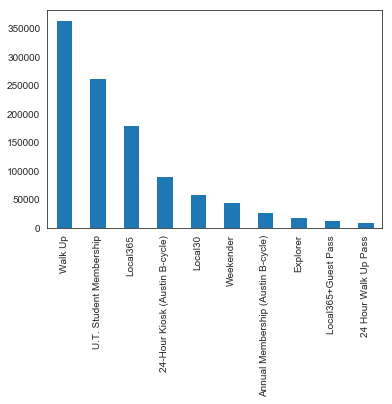

In [8]:
bcycle.membership_type.value_counts()[0:10].plot(kind='bar')

In [9]:
bcycle.membership_type.value_counts(ascending=False)

Walk Up                                               363176
U.T. Student Membership                               262383
Local365                                              179413
24-Hour Kiosk (Austin B-cycle)                         91201
Local30                                                59179
Weekender                                              44767
Annual Membership (Austin B-cycle)                     27895
Explorer                                               17894
Local365+Guest Pass                                    12812
24 Hour Walk Up Pass                                   10093
Single Trip                                             6899
Single Trip                                             5366
3-Day Explorer                                          4740
Local365 ($80 plus tax)                                 4004
Founding Member                                         3461
                                                       ...  
Annual (Kansas City B-cy

## SelectKBest - Bcycle

In [49]:
 test1234 = pd.value_counts(bcycle['bicycle_id'].values, sort=False)

In [50]:
len(test1234)

593

In [36]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer,trip_type
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1,15323.63,0


In [37]:
# drop the extra columns
#X = bcycle[['checkout_kiosk_id', 'odometer', 'unix_checkout_time', 'device_trip_count', 'year']]
X_b = bcycle.drop(['return_kiosk', 'return_kiosk_id', 'checkout_kiosk', 
                   'bicycle_id', 'trip_id'],  1)
# create a value for the various membership types so it can pass and get insight
X_b = pd.get_dummies(X_b, columns=['year', 'hour', 'month', 'checkout_kiosk_id',
                                'day_of_week', 'trip_type','membership_type'])
# predicting for trip type 
Y_b = bcycle['return_kiosk_id']

# test train split function
X_btrain, X_btest, y_btrain, y_btest = train_test_split(X_b, Y_b, test_size=0.25)

In [55]:
selector_b = SelectKBest(k=25)
X_bnew = selector.fit_transform(X_btrain, y_btrain)
names_b = X_b.columns.values[selector.get_support()]
scores_b = selector.scores_[selector.get_support()]
names_scores_b = list(zip(names, scores))
ns_bcycle = pd.DataFrame(data = names_scores_b, columns=['Feat_names', 'F_Scores'])
ns_bcycle_sorted = ns_bcycle.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_bcycle_sorted)

                                        Feat_names      F_Scores
23         membership_type_U.T. Student Membership  36698.461331
21               membership_type_HT Ram Membership   7175.257922
7                                        year_2018   6217.842646
0                               unix_checkout_time   5691.097252
16                          checkout_kiosk_id_4055   5420.752547
17                          checkout_kiosk_id_4059   3240.373279
15                          checkout_kiosk_id_3798   2873.704791
18                          checkout_kiosk_id_4061   2409.092922
19                          checkout_kiosk_id_4062   2190.196286
24                         membership_type_Walk Up   1840.175314
1                                device_trip_count   1272.937506
4                                        year_2015   1170.734433
3                                        year_2014   1135.168718
12                          checkout_kiosk_id_3377   1126.108770
22                       

## SelectKBest - Dockless

In [6]:
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] > 1) & (dockless['trip_distance'] <= 16000)]
len(normal_dockless_rides)

4962659

In [109]:
normal_dockless_rides.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration_seconds      int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
year                       int16
unix_start_time            int32
unix_end_time              int32
trip_duration_minutes    float64
avg_speed                float32
device_id_trip_count       int16
odometer                   int64
trip_type                   int8
dtype: object

In [78]:
normal_dockless_rides.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603,1658,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11,11,5,2018,1543597200,1555088400,191526.72,0.0,1,1658,0


In [111]:
# drop the extra columns
#X = bcycle[['checkout_kiosk_id', 'odometer', 'unix_checkout_time', 'device_trip_count', 'year']]
X_dnew = normal_dockless_rides.drop(['device_id', 'id', 'start_time', 'end_time', 'trip_type',
                    'trip_duration_minutes'], 1)
# create a value for the various membership types so it can pass and get insight
X_dnew = pd.get_dummies(X_dnew, columns=['year', 'hour', 'month', 'vehicle_type','day_of_week'])
    
# predicting for trip type 
y_dnew = normal_dockless_rides['trip_distance']

# test train split function
X_dnewtrain, X_dnewtest, y_dnewtrain, y_dnewtest = train_test_split(X_dnew, y_dnew, test_size=0.25)

In [85]:


inf_test = X_dnew.replace([np.inf, -np.inf], np.nan)
inf_test.dropna()
len(inf_test)


4962659

In [86]:
len(inf_test)

4962659

In [87]:
len(X_dnew)

4962659

In [112]:
X_dnew.max

<bound method DataFrame.max of          trip_duration_seconds  trip_distance  unix_start_time  unix_end_time  \
1                     11491603           1658       1543597200     1555088400   
4                          570            826       1556532900     1556532900   
5                          438           1815       1556533800     1556534700   
6                          391           1519       1556533800     1556533800   
8                          570           1843       1556533800     1556534700   
9                          668           2829       1556532900     1556533800   
10                         390           1283       1556533800     1556534700   
11                         432           1698       1556533800     1556533800   
12                         196            796       1556532900     1556533800   
13                         622           3010       1556532900     1556533800   
14                        1224           1448       1556533800     1556535600 

In [89]:
selector_d = SelectKBest(k=11)
X_dnew = selector_d.fit_transform(X_dnewtrain, y_dnewtrain)
names_d = X_dnew.columns.values[selector_d.get_support()]
scores_d = selector_d.scores_d[selector_d.get_support()]
names_scores_d = list(zip(names_d, scores_d))
ns_dockless = pd.DataFrame(data = names_scores_d, columns=['Feat_names', 'F_Scores'])
ns_dockless_sorted = ns_dockless.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_dockless_sorted)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Bcycle Heatmaps

In [25]:
import seaborn as sns

## Master" Heatmap with all features

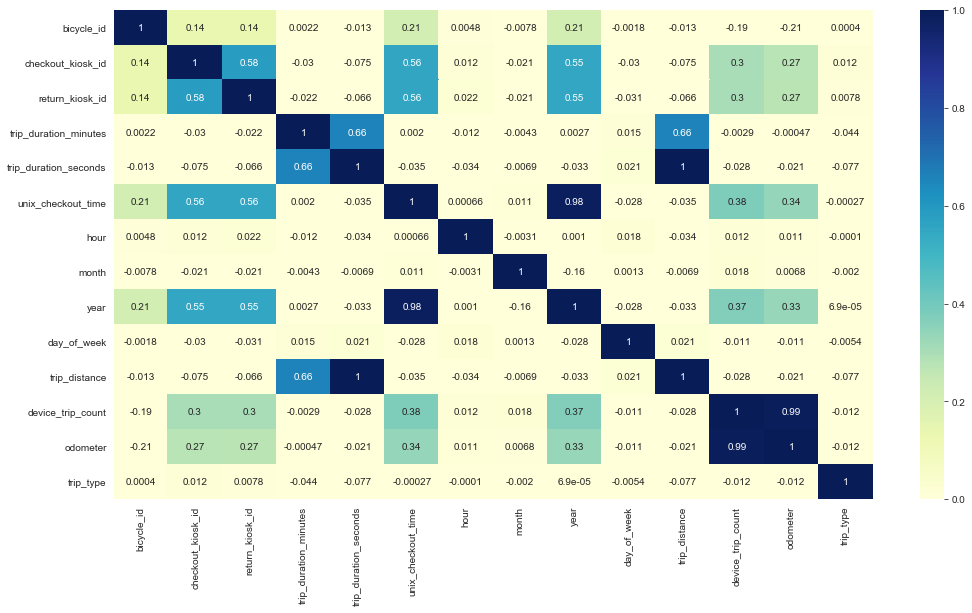

In [26]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Get_dummies heatmaps

## Day of Week

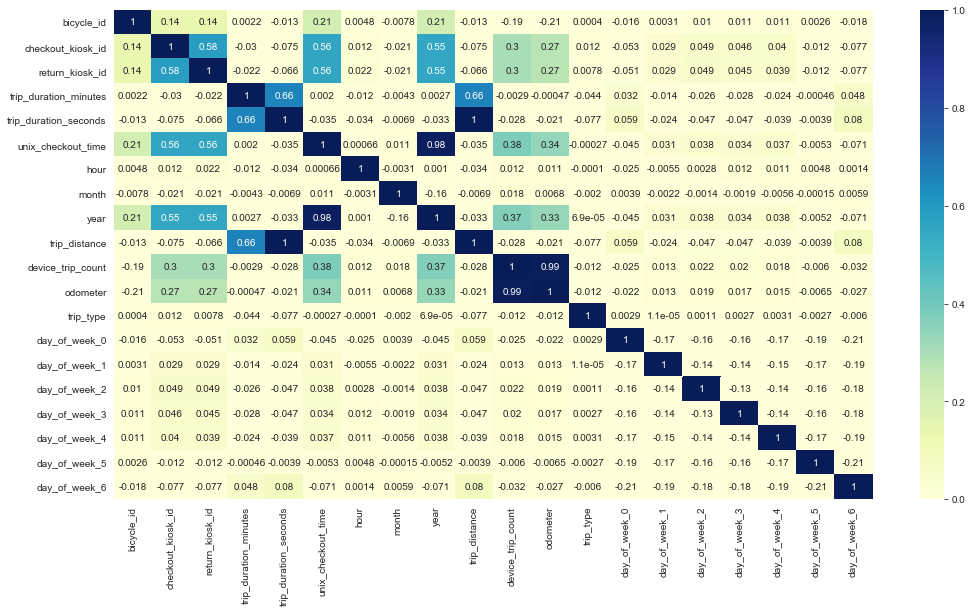

In [28]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['day_of_week'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Hour 

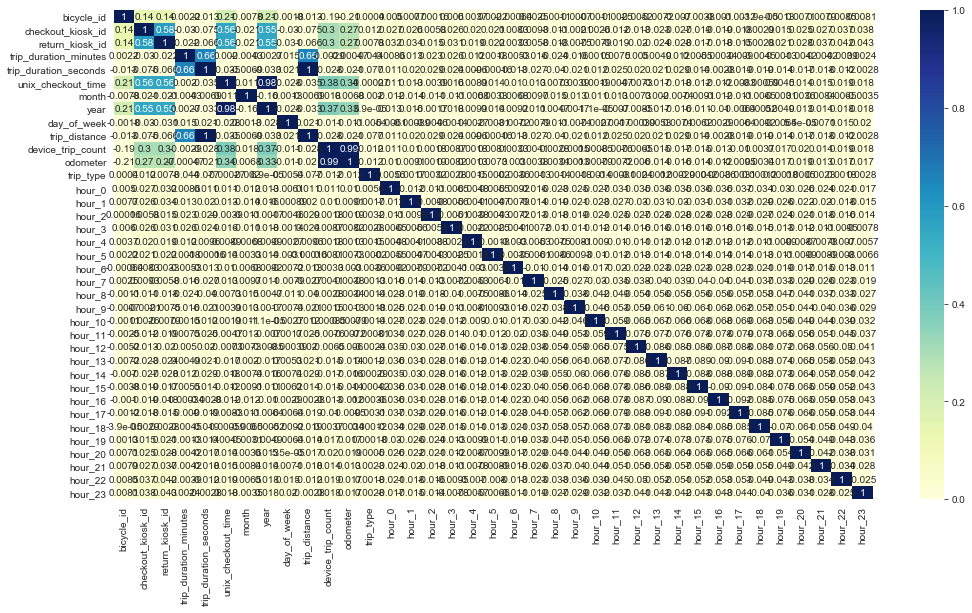

In [30]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['hour'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Month

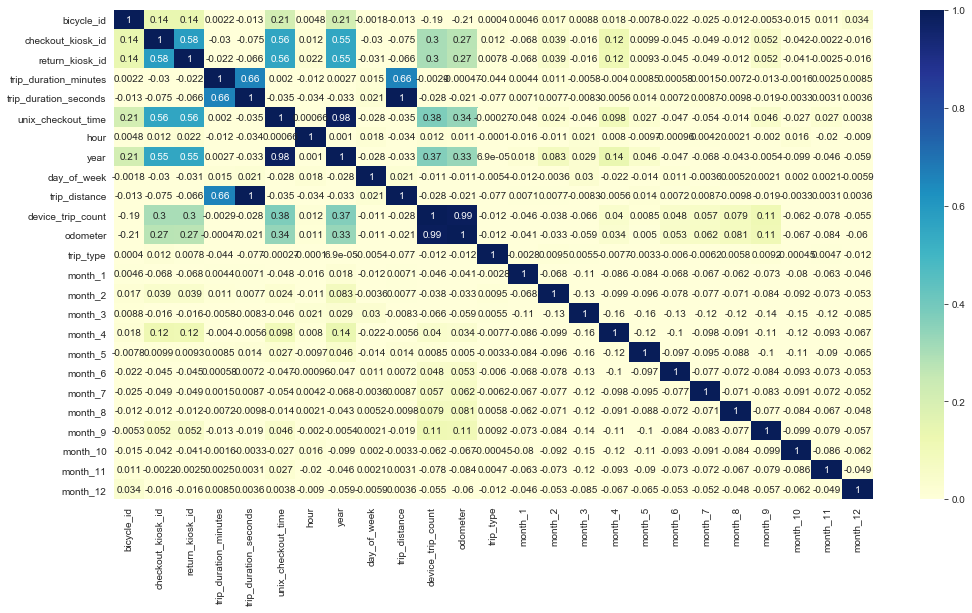

In [31]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['month'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Year

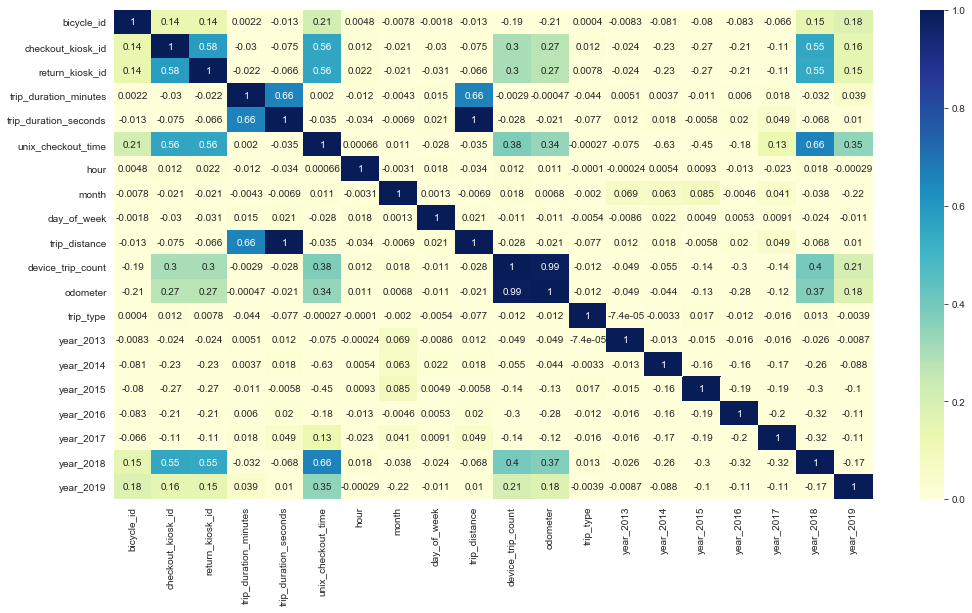

In [32]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['year'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Trip_type

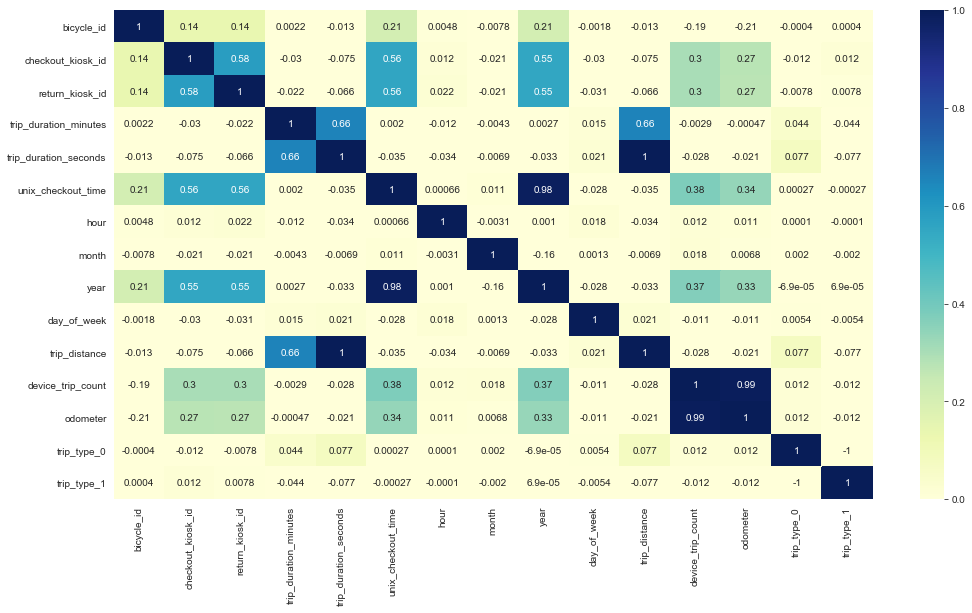

In [27]:
# code for bcycle's heatmap
heat_test = bcycle.drop(['trip_id', 'membership_type'],  1)
# create a value for the various membership types so it can pass and get insight
heat_bcycle = heat_test
heat_bcycle = pd.get_dummies(heat_bcycle, columns=['trip_type'])
corr_bcycle = heat_bcycle.corr()

fig, ax = plt.subplots(figsize=(17,9)) 
heat_bcycle_ax = sns.heatmap(corr_bcycle, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

# Dockless Heatmap

## "Master" Heatmap with all features

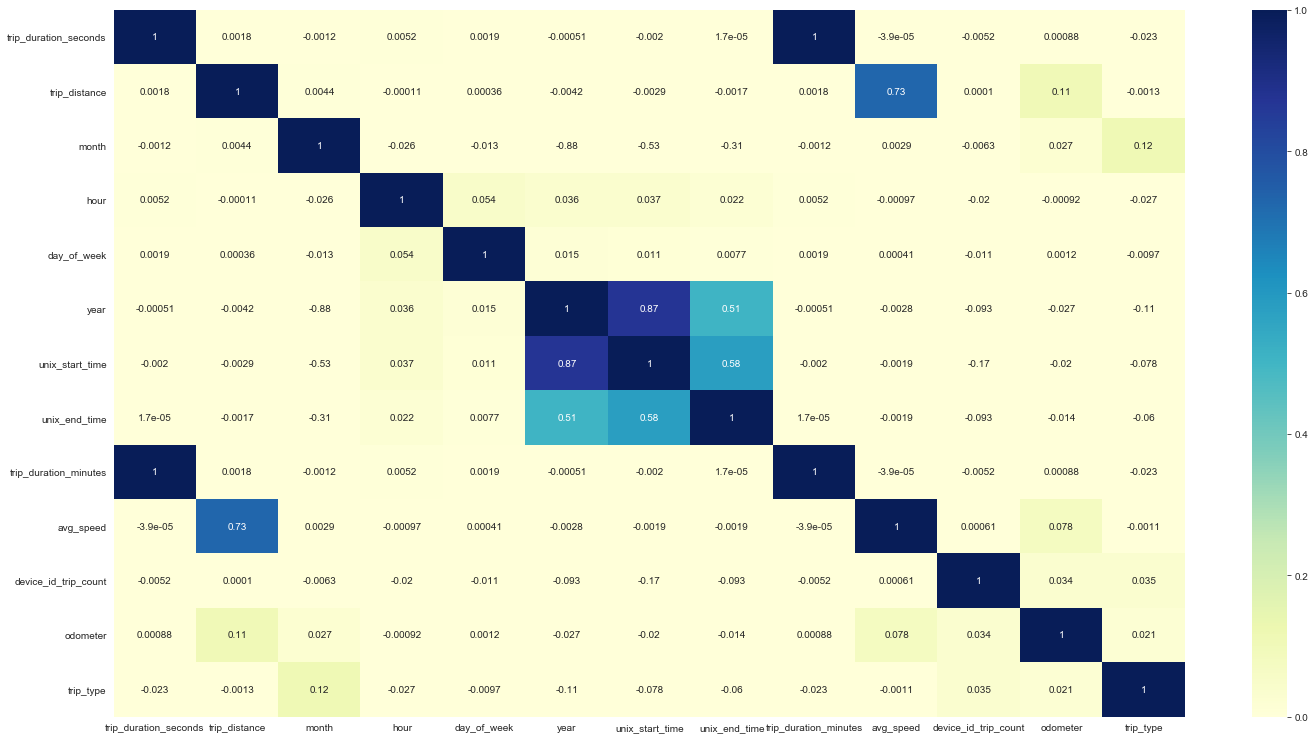

In [84]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(24,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Get_dummies - Day of the week

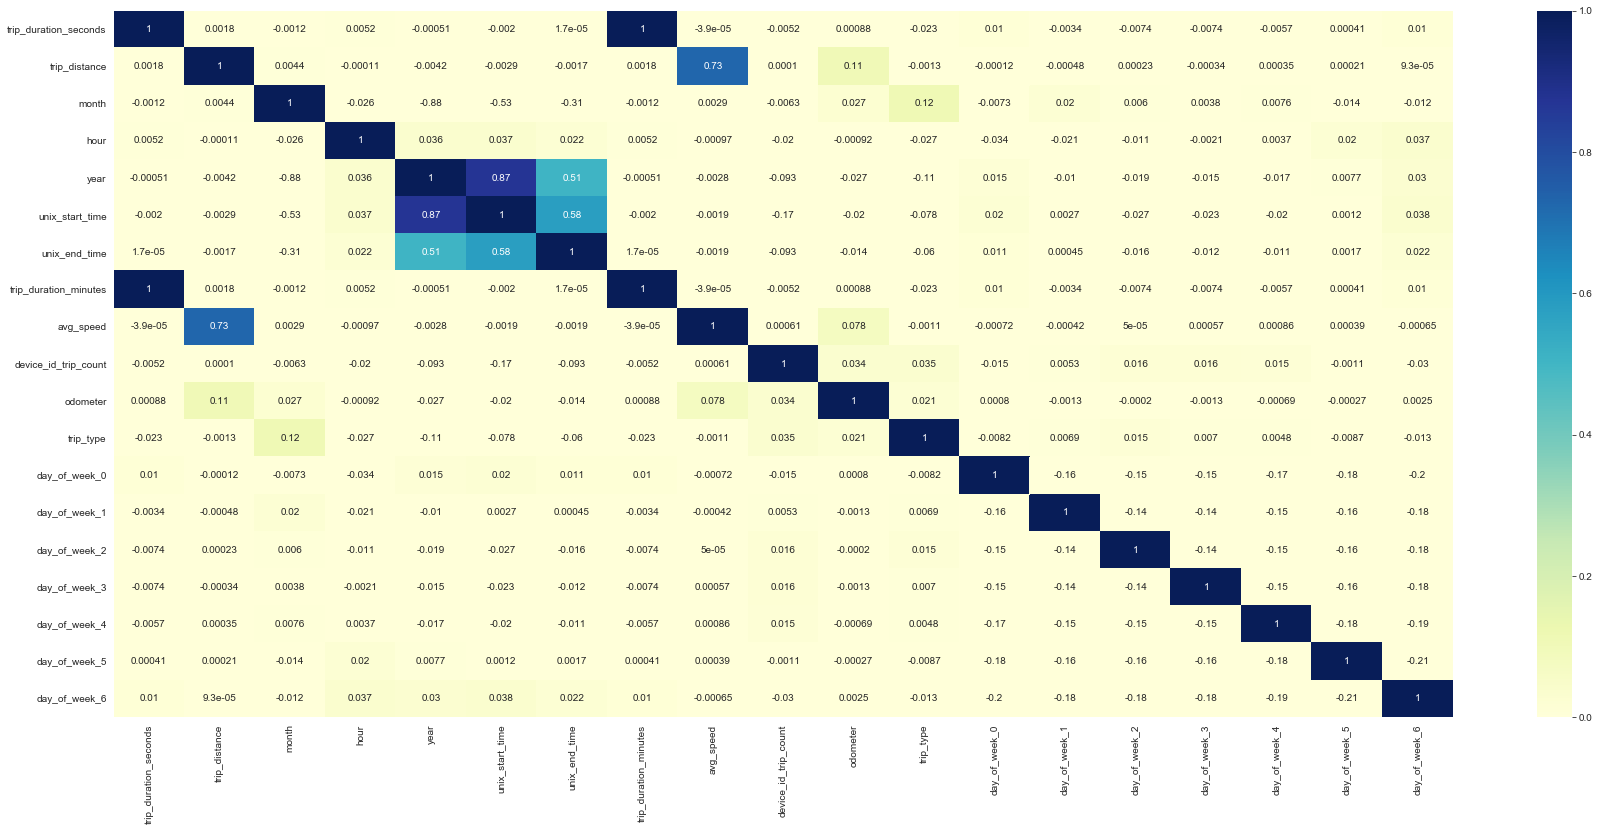

In [85]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['day_of_week'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Get_dummies heatmaps

## Hour

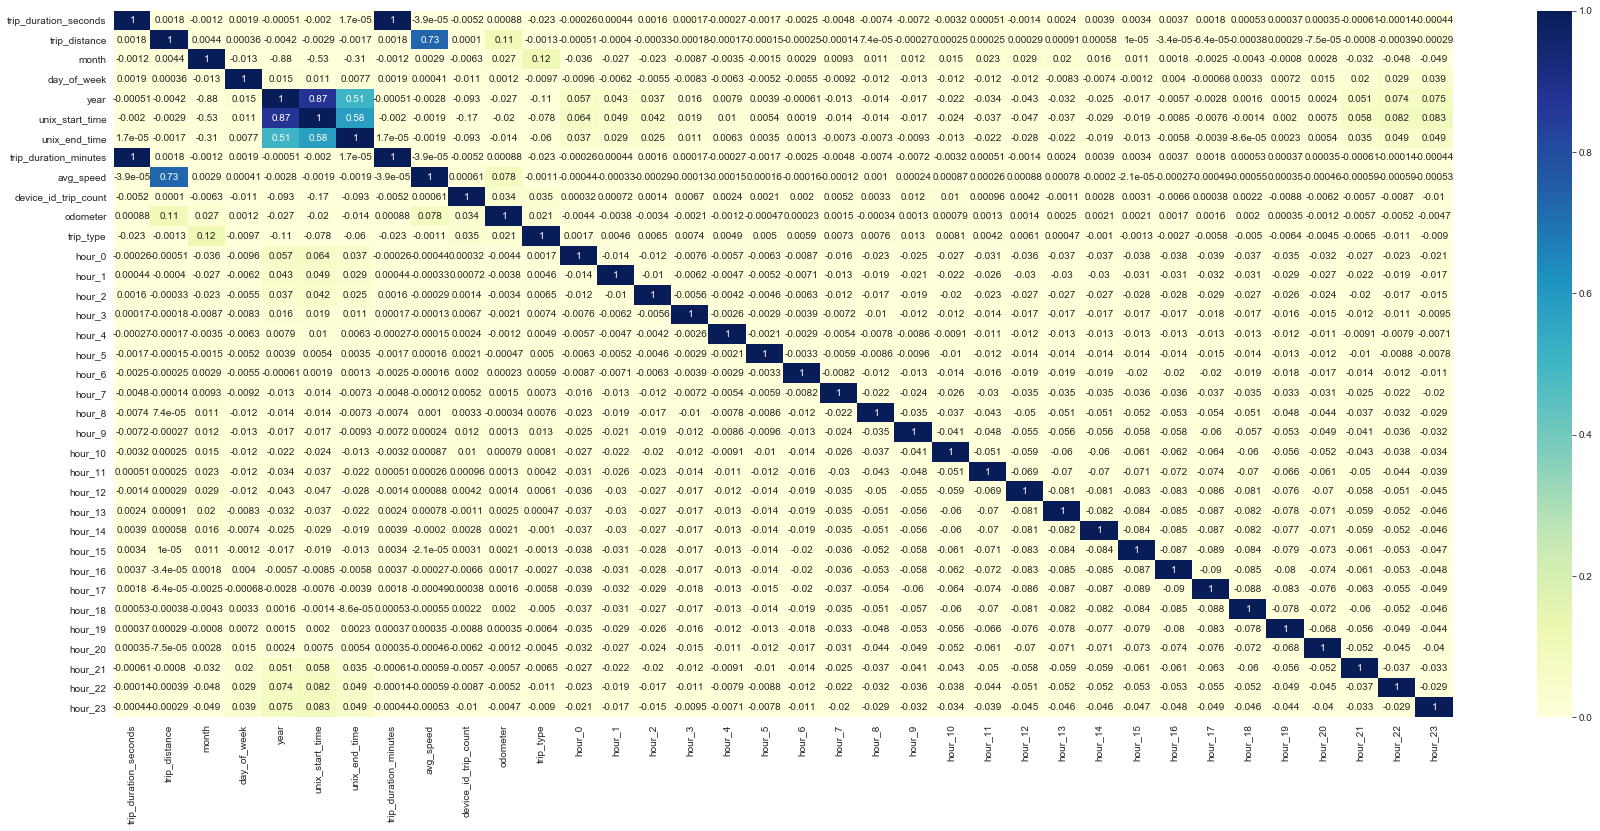

In [86]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['hour'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Month

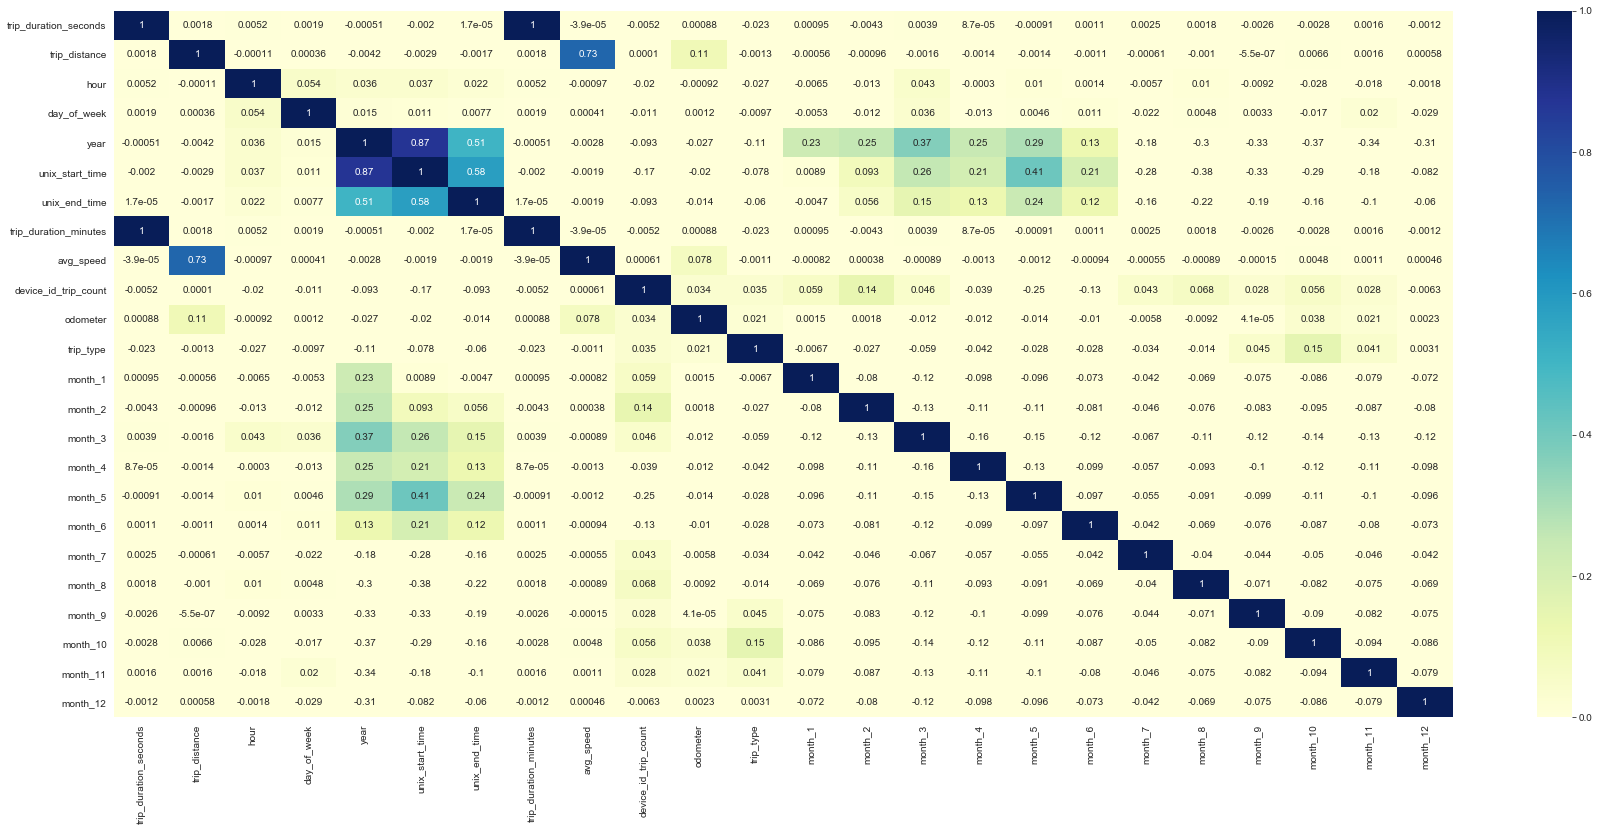

In [87]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['month'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Year

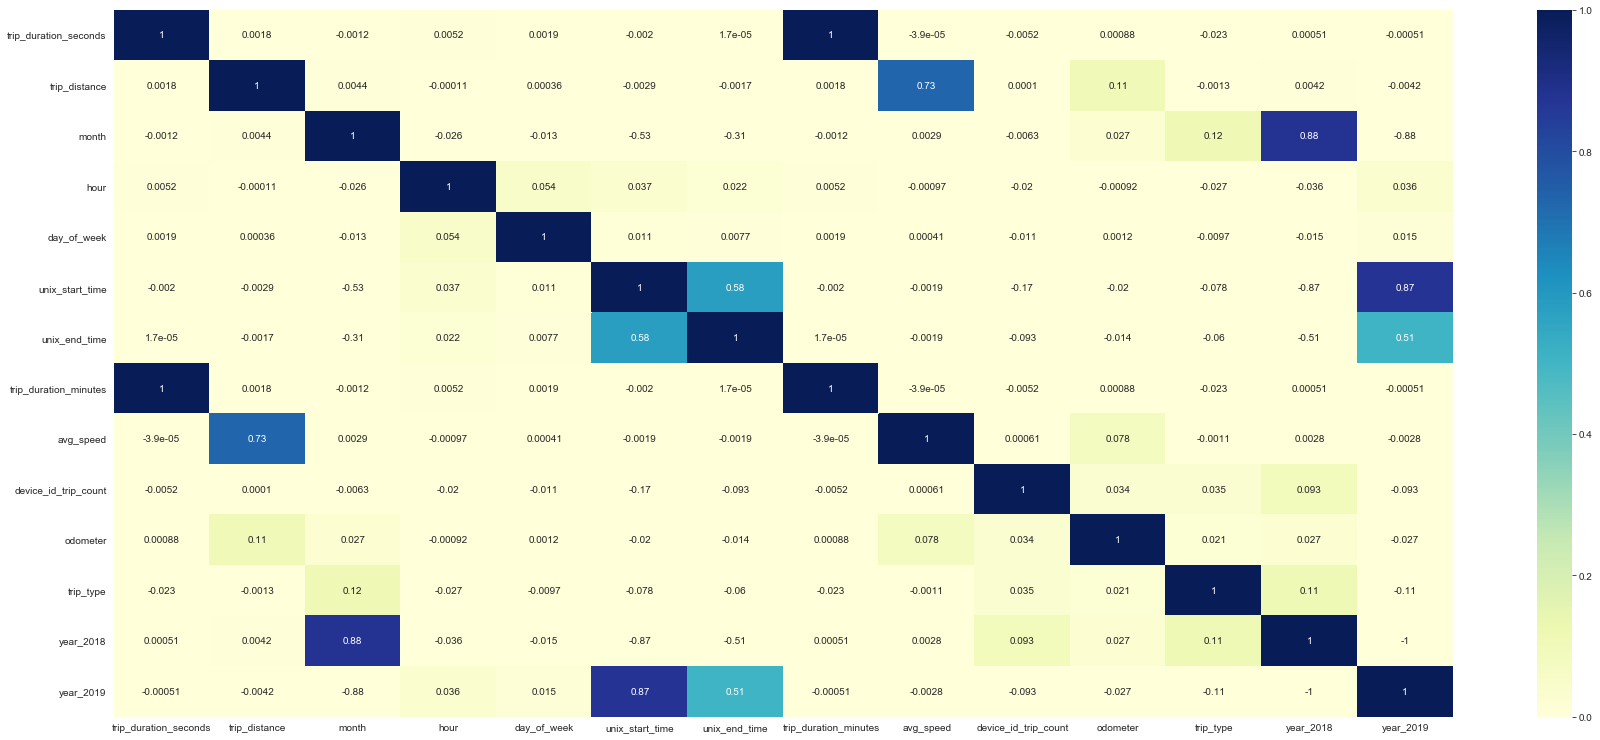

In [88]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['year'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Trip Type

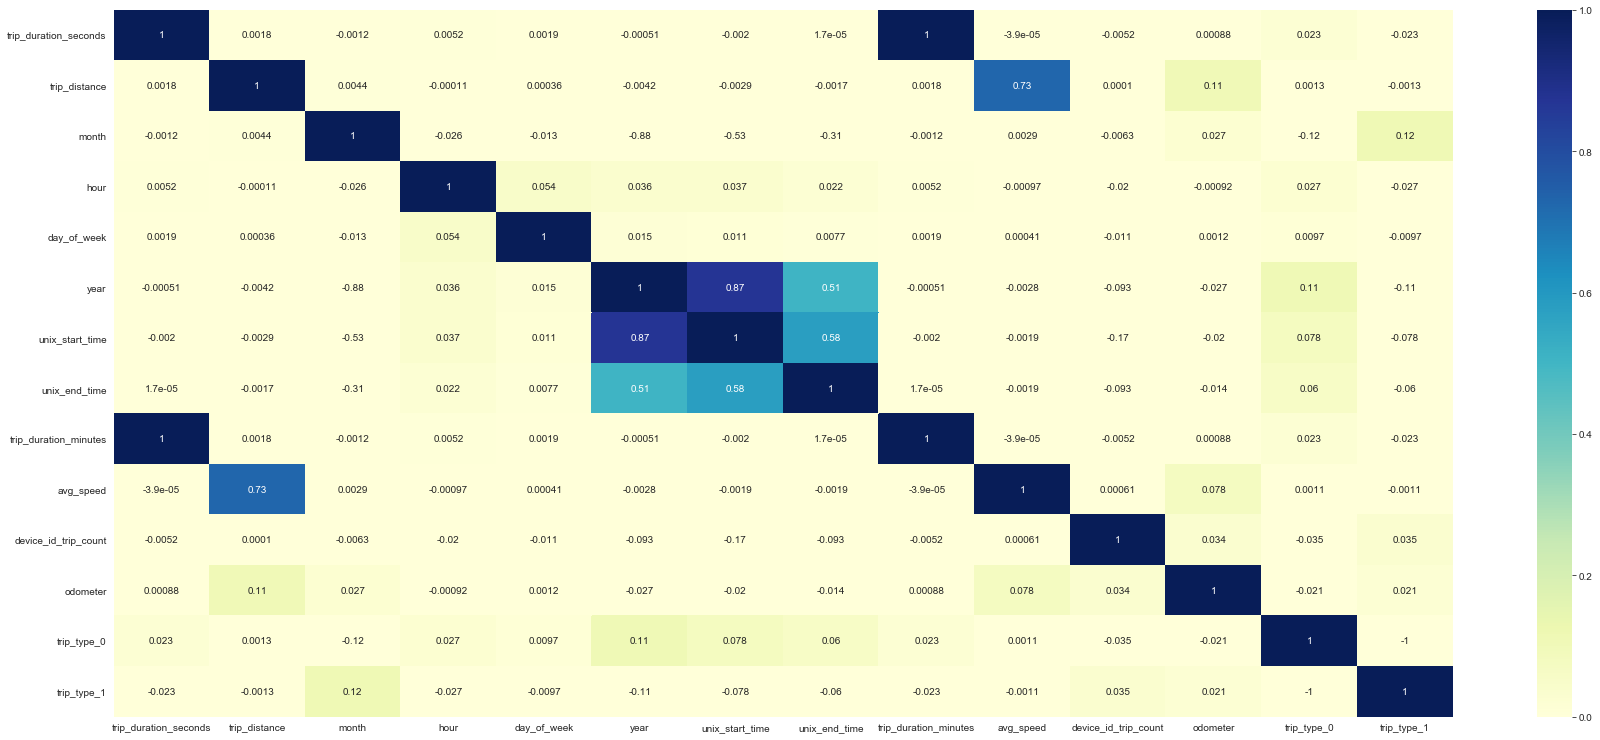

In [89]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['trip_type'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Vehicle Type

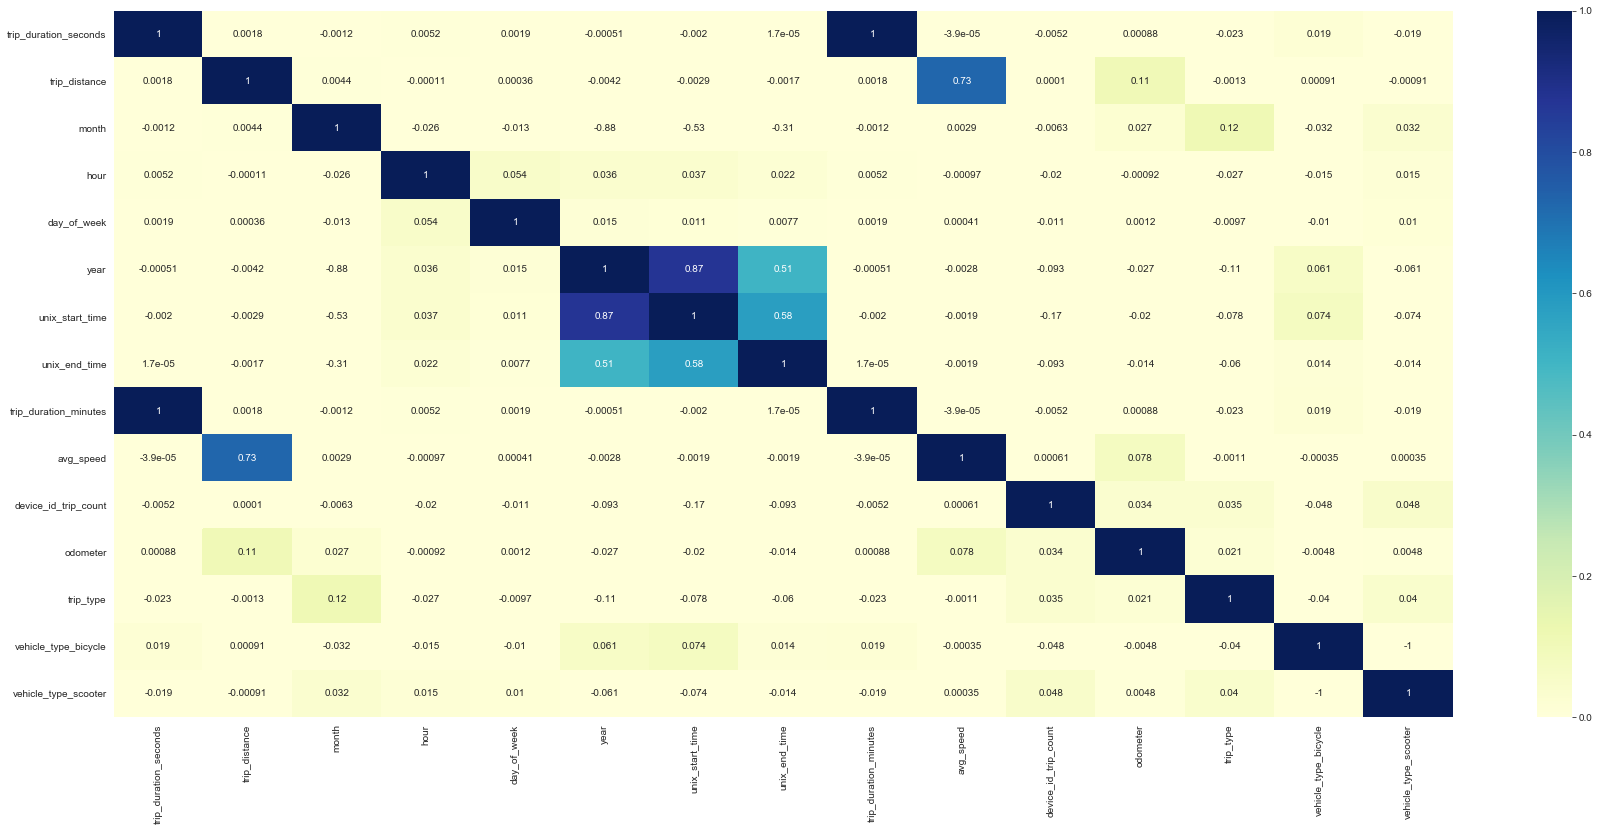

In [90]:
# code for bcycle's heatmap
# create a value for the various membership types so it can pass and get insight
heat_dock = dockless.drop(['id'],  1)
heat_dock = pd.get_dummies(heat_dock, columns=['vehicle_type'])
corr_dockless = heat_dock.corr()

fig, ax = plt.subplots(figsize=(30,13)) 
heat_dock_ax = sns.heatmap(corr_dockless, cmap="YlGnBu", vmin=0, vmax=1, annot=True, cbar=True)

## Pickle 

In [2]:
bcycle = pd.read_pickle('./Austin_B-Cycle:data_clean.pkl')
dockless = pd.read_pickle('./Dockless:data_clean.pkl')
#bcycle.to_pickle('./Austin_B-Cycle:data_clean.pkl')
#dockless.to_pickle('./Dockless:data_clean.pkl')

In [3]:
# test bcycle
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer,trip_type
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1,15323.63,0


In [4]:
# test dockless
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,year,unix_start_time,unix_end_time,trip_duration_minutes,avg_speed,device_id_trip_count,odometer,trip_type
1,08dc0d9c-735e-4006-b9af-60011509e469,255716b5-4a9f-4efc-9967-7a65b3521bac,bicycle,11491603,1658,11/30/2018 11:00:00 AM,04/12/2019 12:00:00 PM,11,11,5,2018,1543597200,1555088400,191526.72,0.0,1,1658,0


# Section V: Modeling

# BCycle: Predicting the Return Kiosk After Checkout

In [44]:
# import libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import f1_score

In [6]:
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] > 1) & (dockless['trip_distance'] <= 16000)]
len(normal_dockless_rides)

4962659

## Pearson's Correlation Coefficient

print(scipy.stats.pearsonr(bcycle['checkout_kiosk_id'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['unix_checkout_time'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['device_trip_count'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['odometer'], bcycle['return_kiosk_id']))

REference: insert link -> mike to provide 1900 paper

## Linear Regression

In [7]:
# In Section 2, real rides were ascertained to be between 3 and 1050 minutes (17.5 hours)
normal_bcycle_rides = bcycle.loc[(bcycle['trip_duration_minutes'] >= 3)
                                    & (bcycle['trip_duration_minutes'] <= 400)]

In [8]:
# random state allows of the same cells sampled each time data_100k is called
data_100k = normal_bcycle_rides.sample(100000, random_state=42)

In [11]:
bcycle_10k = normal_bcycle_rides.sample(10000, random_state=10)
# Original
# drop the extra columns
Xreg = bcycle_10k[['unix_checkout_time', 'device_trip_count',
              'odometer', 'month', 'day_of_week', 'hour',
                'year', 'trip_type']]
#X = bcycle.drop(['trip_id', 'membership_type', 'b' 'trip_type'],  1)
# create a value for the various membership types so it can pass and get insight
Xreg = pd.get_dummies(Xreg, columns=['month', 'day_of_week',
                                     'year', 'hour', 'trip_type'])
# get dummies left out: 'checkout_kiosk_id', 'return_kiosk_id'
# predicting for trip type 
yreg = bcycle_10k['trip_duration_minutes']

# test train split function
Xreg_train, Xreg_test, yreg_train, yreg_test = train_test_split(Xreg, yreg, test_size=0.25)

In [12]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#sns.scatterplot(data=bcycle_10k, x='hour', y='trip_duration_minutes', hue='day_of_week')

# Instantiate our model.
regr = LinearRegression()

# Fit our model to our data.
regr.fit(Xreg, yreg)
y_predict = regr.predict(Xreg)
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [  2.47933921e-07  -1.40839556e-02   2.70125668e-06   1.00926368e+00
   3.00745654e+00   1.69203161e+00   2.69922155e+00   2.63421856e+00
   2.30620381e+00   2.57284210e+00  -2.23156866e+00  -3.08642492e+00
  -5.14336271e+00  -1.29921294e+00  -4.16066861e+00   5.04831949e+00
  -1.00422649e+00  -3.96140710e+00  -4.00272526e+00  -3.44098490e+00
   1.10232181e-02   7.35000104e+00   2.48418371e+01   1.66003382e+01
   6.29618565e+00   9.91736304e-01  -4.36906259e+00  -2.00446289e+01
  -2.43164059e+01  -6.74189752e+00  -5.17474688e+00   1.01187261e+00
   9.82651469e+00  -3.44577509e+00  -5.41982292e+00   4.10120278e+00
  -5.62536887e+00  -4.66219261e+00  -2.27767433e+00   5.09888975e+00
   7.48515906e+00   5.04156117e+00   3.65918251e+00   5.01449536e+00
   2.74343141e+00   3.23561854e-01  -4.32070001e-01  -1.23299801e+00
   2.46932225e+00  -3.49732075e+00  -3.09518110e+00  -2.87186854e+00
  -2.29827681e+00   0.00000000e+00]
Intercept: 
 -340.692201292


In [13]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,unix_checkout_time,hour,month,year,day_of_week,trip_distance,device_trip_count,odometer,trip_type
0,9900285854,Annual (San Antonio B-cycle),207,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,1414347120,13,10,2014,0,15323.63,1,15323.63,0


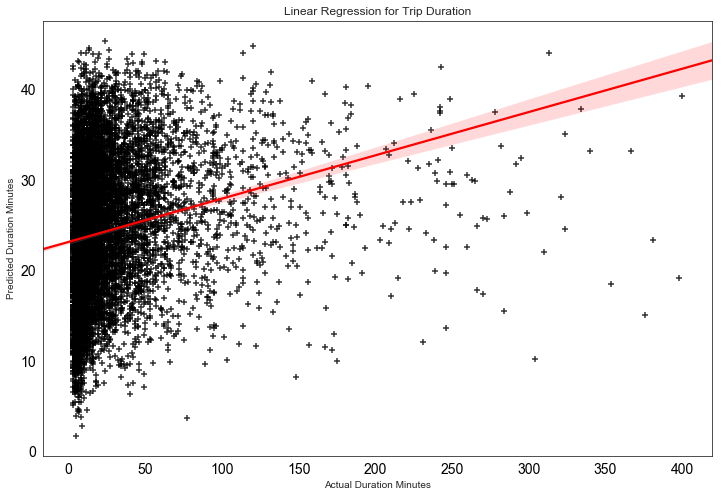

In [16]:
ax = sns.regplot(yreg, y_predict, data=bcycle_10k, x_estimator=None, x_bins=None, x_ci='ci', 
            scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, 
            lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, 
            dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='+',
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=None)
ax.set_title('Linear Regression for Trip Duration')
ax.set_ylabel('Predicted Duration Minutes')
ax.set_xlabel('Actual Duration Minutes')
ax.figure.set_size_inches(12,8)
ax.tick_params(labelsize=14,labelcolor="black")

## Take the log of the independent variable 

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


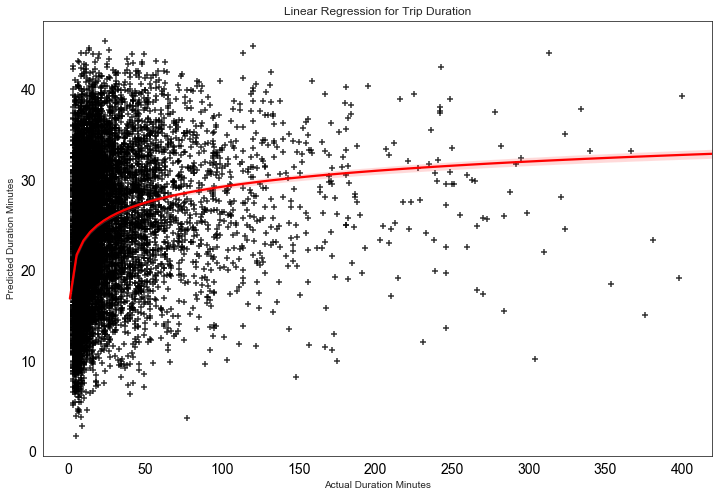

In [17]:
ax = sns.regplot(yreg, y_predict, data=bcycle_10k, x_estimator=None, x_bins=None, x_ci='ci', 
            scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, 
            lowess=False, robust=False, logx=True, x_partial=None, y_partial=None, truncate=False, 
            dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='+',
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=None)
ax.set_title('Linear Regression for Trip Duration')
ax.set_ylabel('Predicted Duration Minutes')
ax.set_xlabel('Actual Duration Minutes')
ax.figure.set_size_inches(12,8)
ax.tick_params(labelsize=14,labelcolor="black")

# Multinomial Classification

## There are 96 kiosks available to predict where they will be returned

In [18]:
kiosk_length_r = pd.value_counts(bcycle['return_kiosk_id'].values, sort=False)
kiosk_length_c = pd.value_counts(bcycle['checkout_kiosk_id'].values, sort=False)
print(len(kiosk_length_r))
print(len(kiosk_length_c))

96
96


In [19]:
# Original
# drop the extra columns
X96 = bcycle[['checkout_kiosk_id', 'odometer', 'unix_checkout_time', 'device_trip_count', 'year']]
#X = bcycle.drop(['trip_id', 'membership_type', 'b' 'trip_type'],  1)
# create a value for the various membership types so it can pass and get insight
X96 = pd.get_dummies(X96, columns=['checkout_kiosk_id', 'year'])
# predicting for trip type 
y96 = bcycle['return_kiosk_id']

# test train split function
X96_train, X96_test, y96_train, y96_test = train_test_split(X96, y96, test_size=0.25)

In [20]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('return_kiosk_id ~ checkout_kiosk_id + unix_checkout_time + device_trip_count + odometer',
                  data=bcycle).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        return_kiosk_id   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 2.057e+05
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        07:33:56   Log-Likelihood:            -8.4152e+06
No. Observations:             1122091   AIC:                         1.683e+07
Df Residuals:                 1122086   BIC:                         1.683e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3820.7737     15

In [21]:
print(scipy.stats.pearsonr(bcycle['checkout_kiosk_id'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['unix_checkout_time'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['device_trip_count'], bcycle['return_kiosk_id']))
print(scipy.stats.pearsonr(bcycle['odometer'], bcycle['return_kiosk_id']))

(0.583183531119567, 0.0)
(0.55667076358762413, 0.0)
(0.30308105384545936, 0.0)
(0.2730700504799608, 0.0)


## Bcycle - Naive Bayes Multinomial Classification

In [22]:
# Naive Bayes Classifier 
gnb = GaussianNB() # Specify constructor parameter
cv_gnb = cross_val_score(gnb, X96_train, y96_train, cv=5)
print("Cross Validation Scorres: ", cv_gnb)
print("Cross Validation Mean: ", cv_gnb.mean())
print("Cross Validation Score Variance: ", cv_gnb.var())

Cross Validation Scorres:  [ 0.09145179  0.09161602  0.0912337   0.0918944   0.09120622]
Cross Validation Mean:  0.0914804250873
Cross Validation Score Variance:  6.53286102063e-08


In [23]:
seed = 7
test_size = 0.25
X96_train, X96_test, y96_train, y96_test = train_test_split(X96, y96, test_size=test_size,
    random_state=seed)

# fit model on training data
gnb.fit(X96_train, y96_train)

# Classify, storing the result in a new variable.
y_pred_gnb = gnb.predict(X96_test)

# make predictions for test data
predictions_gnb = gnb.predict(X96_test)

# evaluate predictions
accuracy_gnb = accuracy_score(y96_test, predictions_gnb)
print("Accuracy: %.2f%%" % (accuracy_gnb * 100.0))

Accuracy: 9.13%


In [24]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X96.shape,
    (y96_test != y_pred_gnb).sum()
))

print('\nR-squared:')
print(gnb.score(X96_test, y96_test))

Number of mislabeled points out of a total (1122091, 106) points : 254914

R-squared:
0.0912901972387


In [25]:
results_gnb = confusion_matrix(y96_test, y_pred_gnb) 
print('\nConfusion Matrix :')
print(results_gnb) 
print('Accuracy Score :',accuracy_score(y96_test, y_pred_gnb))
print('\nReport : ')
print(classification_report(y96_test, y_pred_gnb))


Confusion Matrix :
[[  0   0   0 ...,   0   0   0]
 [  0 188   0 ...,   0   0   0]
 [  0 104   0 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]
Accuracy Score : 0.0912901972387

Report : 


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        1001       0.00      0.00      0.00         2
        1002       0.02      0.75      0.04       251
        1003       0.00      0.00      0.00       152
        1005       0.00      0.00      0.00        71
        1006       0.00      0.00      0.00       389
        1007       0.00      0.00      0.00      1195
        1008       0.00      0.00      0.00      1038
        2494       0.10      0.01      0.01      9411
        2495       0.00      0.00      0.00      8703
        2496       0.00      0.00      0.00      4110
        2497       0.00      0.00      0.00      5778
        2498       0.00      0.00      0.00      8382
        2499       0.05      0.52      0.10     10259
        2500       0.00      0.00      0.00       104
        2501       0.00      0.00      0.00      7941
        2502       0.00      0.00      0.00      4865
        2503       0.00      0.00      0.00      4698
        2504       0.00    

## Bcycle - Random Forest Multinomial Classification

In [101]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, 
                                      min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                      max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                      min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                                      random_state=None, verbose=0, warm_start=False)
# {0:1,1:2}
cv_rfc = cross_val_score(rfc, X96_train, y96_train, cv=5)
print("Cross Validation Scores: ", cv_rfc)
print("Cross Validation Mean: ", cv_rfc.mean())
print("Cross Validation Score Varaince: ", cv_rfc.var())

KeyboardInterrupt: 

In [58]:
seed = 7
test_size = 0.25
X96_train, X96_test, y96_train, y96_test = train_test_split(X96, y96, test_size=test_size,
    random_state=seed)

# fit model on training data
rfc.fit(X96_train, y96_train)

# Classify, storing the result in a new variable.
y_pred_rfc = rfc.predict(X96_test)

# make predictions for test data
predictions_rfc = rfc.predict(X96_test)

# evaluate predictions
accuracy_rfc = accuracy_score(y96_test, predictions_rfc)
print("Accuracy: %.2f%%" % (accuracy_rfc * 100.0))

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 13.74%


In [59]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X96.shape[0],
    (y96_test != y_pred_rfc).sum()
))

print('\nR-squared:')
print(rfc.score(X96_test, y96_test))

Number of mislabeled points out of a total 1122091 points : 241993

R-squared:
0.137350591574


In [60]:
# RFC confusion matrix
results_rfc = confusion_matrix(y96_test, y_pred_rfc) 
print('\nConfusion Matrix :')
print(results_rfc) 
print('Accuracy Score :',accuracy_score(y96_test, y_pred_rfc))
print('\nReport : ')
print(classification_report(y96_test, y_pred_rfc))


Confusion Matrix :
[[  0   0   0 ...,   0   0   0]
 [  0  24   1 ...,   0   0   0]
 [  0   6   7 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  17   2   0]
 [  0   0   0 ...,   3 167  22]
 [  0   0   0 ...,   4  33  92]]
Accuracy Score : 0.137350591574

Report : 
              precision    recall  f1-score   support

        1001       0.00      0.00      0.00         2
        1002       0.07      0.10      0.08       251
        1003       0.05      0.05      0.05       152
        1005       0.11      0.10      0.10        71
        1006       0.10      0.14      0.12       389
        1007       0.07      0.09      0.07      1195
        1008       0.06      0.08      0.07      1038
        2494       0.11      0.15      0.13      9411
        2495       0.10      0.13      0.11      8703
        2496       0.07      0.08      0.07      4110
        2497       0.11      0.14      0.13      5778
        2498       0.11      0.13      0.12      8382
        2499       0.11      0.13 

# Dockless Models - Predicting False Starts

# Down sample majority class

In [26]:
# creating dataframe of rides from 0 to 16000 meters
false_start_rides = dockless.loc[(dockless['trip_distance'] <= 16000)]
len(normal_dockless_rides)

4962659

In [27]:
# Separate majority and minority classes
df_majority = false_start_rides[false_start_rides.trip_type==0]
df_minority = false_start_rides[false_start_rides.trip_type==1]

In [28]:
from sklearn.utils import resample
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=464633,     # to match minority class
                                 random_state=123) # reproducible results
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.trip_type.value_counts()

1    464633
0    464633
Name: trip_type, dtype: int64

In [29]:
# Separate input features (X) and target variable (y)
ydown = df_downsampled['trip_type']
Xdown = df_downsampled[['unix_start_time', 'unix_end_time', 'vehicle_type',
                       'month', 'hour', 'day_of_week', 'odometer', 'device_id_trip_count']]
Xdown = pd.get_dummies(Xdown, columns=['vehicle_type', 'month', 'hour', 'day_of_week'])
 
# test train split function
Xdown_train, Xdown_test, ydown_train, ydown_test = train_test_split(Xdown, ydown, test_size=0.25)

In [30]:
# Original
# drop the extra columns
Xf = false_start_rides[['unix_start_time', 'unix_end_time', 'vehicle_type',
                       'month', 'hour', 'day_of_week', 'odometer', 'device_id_trip_count']]
#X = bcycle.drop(['trip_id', 'membership_type', 'b' 'trip_type'],  1)
# create a value for the various membership types so it can pass and get insight
Xf = pd.get_dummies(Xf, columns=['vehicle_type', 'month', 'hour', 'day_of_week'])
# predicting for trip type 
yf = false_start_rides['trip_type']

# test train split function
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.25)

## Logistic Regression - False starts

In [105]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty="l1", dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, random_state=42, solver="saga", 
                         max_iter=150, multi_class="ovr", verbose=1, warm_start=False, 
                         n_jobs=None)

cv_lr = cross_val_score(lr, Xdown_train, ydown_train, cv=5)
print(cv_lr)
print("Cross Validation Mean: ", cv_lr.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 133 seconds


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 131 seconds


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 131 seconds


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 130 seconds


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 131 seconds
[ 0.50173254  0.5020518   0.50176483  0.50199801  0.50200518]
Cross Validation Mean:  0.501910470293


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


In [88]:
seed = 7
test_size = 0.25
#lr_train_test = train_test_split(Xf_train, yf_train, test_size=test_size,
    #random_state=seed)
# fit model on training data
lr.fit(Xdown_train, ydown_train)
# make predictions for test data
predictions = lr.predict(Xdown_test)
# evaluate predictions
accuracy_lr = accuracy_score(ydown_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))

Accuracy: 50.23%


In [89]:
# Classify, storing the result in a new variable.
y_pred_lr = lr.predict(Xdown_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    Xdown.shape[0],
    (ydown_test != y_pred_lr).sum()
))

Number of mislabeled points out of a total 929266 points : 115623


In [90]:
# Logistic regression confusion matrix
results_lr = confusion_matrix(ydown_test, y_pred_lr) 
print('\nConfusion Matrix :')
print(results_lr) 
print('Accuracy Score :',accuracy_score(ydown_test, y_pred_lr))
print('\nReport : ')
print(classification_report(ydown_test, y_pred_lr))

print('\nR-squared:')
print(lr.score(Xdown_test, ydown_test))


Confusion Matrix :
[[115372    925]
 [114698   1322]]
Accuracy Score : 0.502305040096

Report : 
              precision    recall  f1-score   support

           0       0.50      0.99      0.67    116297
           1       0.59      0.01      0.02    116020

   micro avg       0.50      0.50      0.50    232317
   macro avg       0.54      0.50      0.34    232317
weighted avg       0.54      0.50      0.34    232317


R-squared:
0.502305040096


In [26]:
# l1 logistic regression
#from sklearn.linear_model import LogisticRegression
#lasso = LogisticRegression(random_state=7, penalty='l1', solver='liblinear')

## Naive Bayes - False Starts

In [78]:
# Naive Bayes Classifier 
gnb_fs = GaussianNB() # Specify constructor parameter
cv_gnb_fs = cross_val_score(gnb_fs, Xdown_train, ydown_train, cv=5)
print("Cross Validation Scorres: ", cv_gnb_fs)
print("Cross Validation Mean: ", cv_gnb_fs.mean())
print("Cross Validation Score Variance: ", cv_gnb_fs.var())

Cross Validation Scorres:  [ 0.49851138  0.49939737  0.49911758  0.49840375  0.49933639]
Cross Validation Mean:  0.4989532954
Cross Validation Score Variance:  1.73649632557e-07


In [79]:
seed = 7
test_size = 0.25
#Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.25)

# fit model on training data
gnb_fs.fit(Xdown_train, ydown_train)

# Classify, storing the result in a new variable.
y_pred_gnb_fs = gnb_fs.predict(Xdown_test)

# make predictions for test data
predictions_gnb_fs = gnb_fs.predict(Xdown_test)

# evaluate predictions
accuracy_gnb_fs = accuracy_score(ydown_test, predictions_gnb_fs)
print("Accuracy: %.2f%%" % (accuracy_gnb_fs * 100.0))

Accuracy: 49.95%


In [80]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    Xdown.shape,
    (ydown_test != y_pred_gnb_fs).sum()
))

print('\nR-squared:')
print(gnb_fs.score(Xdown_test, ydown_test))

Number of mislabeled points out of a total (929266, 49) points : 116265

R-squared:
0.499541574659


In [81]:
results_gnb_fs = confusion_matrix(ydown_test, y_pred_gnb_fs) 
print('\nConfusion Matrix :')
print(results_gnb_fs) 
print('Accuracy Score :',accuracy_score(ydown_test, y_pred_gnb_fs))
print('\nReport : ')
print(classification_report(ydown_test, y_pred_gnb_fs))


Confusion Matrix :
[[114852   1445]
 [114820   1200]]
Accuracy Score : 0.499541574659

Report : 
              precision    recall  f1-score   support

           0       0.50      0.99      0.66    116297
           1       0.45      0.01      0.02    116020

   micro avg       0.50      0.50      0.50    232317
   macro avg       0.48      0.50      0.34    232317
weighted avg       0.48      0.50      0.34    232317



## Random Forest Classifier - false starts

In [32]:
rfc_fs = ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                                         min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                         max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                         min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                                         random_state=42, verbose=0, warm_start=False, class_weight="balanced")
cv_rfc_fs = cross_val_score(rfc_fs, Xdown_train, ydown_train, cv=5)
print("Cross Validation Scores: ", cv_rfc_fs)
print("Cross Validation Mean: ", cv_rfc_fs.mean())
print("Cross Validation Score Varaince: ", cv_rfc_fs.var())

Cross Validation Scores:  [ 0.67168376  0.67428079  0.67329077  0.67330512  0.67373322]
Cross Validation Mean:  0.673258732668
Cross Validation Score Varaince:  7.50690304001e-07


In [33]:
seed = 7
test_size = 0.25
#Xdown_train, Xdown_test, ydown_train, ydown_test = train_test_split(Xdown, ydown, test_size=test_size,
    #random_state=seed)

# fit model on training data
rfc_fs.fit(Xdown_train, ydown_train)

# Classify, storing the result in a new variable.
y_pred_rfc_fs = rfc_fs.predict(Xdown_test)

# make predictions for test data
predictions_rfc_fs = rfc_fs.predict(Xdown_test)

# evaluate predictions
accuracy_rfc_fs = accuracy_score(ydown_test, predictions_rfc_fs)
print("Accuracy: %.2f%%" % (accuracy_rfc_fs * 100.0))

Accuracy: 67.57%


In [34]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    Xdown.shape[0],
    (ydown_test != y_pred_rfc_fs).sum()
))

print('\nR-squared:')
print(rfc_fs.score(Xdown_test, ydown_test))

Number of mislabeled points out of a total 929266 points : 75346

R-squared:
0.675675908349


In [35]:
# RFC confusion matrix
results_rfc_fs = confusion_matrix(ydown_test, y_pred_rfc_fs) 
print('\nConfusion Matrix :')
print(results_rfc_fs) 
print('Accuracy Score :',accuracy_score(ydown_test, y_pred_rfc_fs))
print('\nReport : ')
print(classification_report(ydown_test, y_pred_rfc_fs))


Confusion Matrix :
[[79355 36558]
 [38788 77616]]
Accuracy Score : 0.675675908349

Report : 
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    115913
           1       0.68      0.67      0.67    116404

   micro avg       0.68      0.68      0.68    232317
   macro avg       0.68      0.68      0.68    232317
weighted avg       0.68      0.68      0.68    232317



## XGBoost - false starts

In [91]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()

cv_xgb = cross_val_score(xgb, Xdown_train, ydown_train, cv=5)
print(cv_xgb)
print("Cross Validation Mean: ", cv_xgb.mean())

#cv_xgb.var()

[ 0.67448401  0.67755937  0.67646173  0.67658137  0.67668898]
Cross Validation Mean:  0.676355088294


In [94]:
seed = 7
test_size = 0.25
#xgb_train_test = train_test_split(X, Y, test_size=test_size,
    #random_state=seed)
    
# fit model on training data
xgb.fit(Xdown_train, ydown_train)
# make predictions for test data
predictions = xgb.predict(Xdown_test)
# evaluate predictions
accuracy_xgb = accuracy_score(ydown_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 67.51%


In [95]:
# Classify, storing the result in a new variable.
y_pred_xgb = xgb.predict(Xdown_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    Xdown.shape[0],
    (ydown_test != y_pred_xgb).sum()
))

Number of mislabeled points out of a total 929266 points : 75470


In [97]:
# XGB confusion matrix
results_xgb = confusion_matrix(ydown_test, y_pred_xgb) 
print('\nConfusion Matrix :')
print(results_xgb) 
print('Accuracy Score :',accuracy_score(ydown_test, y_pred_xgb))
print('\nReport : ')
print(classification_report(ydown_test, y_pred_xgb))

print('\nR-squared:')
print(xgb.score(Xdown_test, ydown_test))


Confusion Matrix :
[[87156 29141]
 [46329 69691]]
Accuracy Score : 0.6751421549

Report : 
              precision    recall  f1-score   support

           0       0.65      0.75      0.70    116297
           1       0.71      0.60      0.65    116020

   micro avg       0.68      0.68      0.68    232317
   macro avg       0.68      0.68      0.67    232317
weighted avg       0.68      0.68      0.67    232317


R-squared:
0.6751421549


## Of all the models, RFC did best, so I'll focus on tuning that one

In [37]:
from sklearn.metrics import roc_curve, auc
y_pred = rfc_fs.predict(Xdown_test) 
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydown_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.67569474703337229

## Tune for n-estimators

TypeError: unhashable type: 'list'

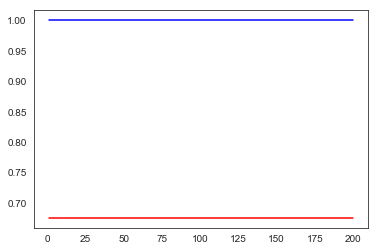

In [49]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    rfc_fs.fit(Xdown_train, ydown_train)   
    
    train_pred = rfc_fs.predict(Xdown_train)
      
    false_positive_rate, true_positive_rate, thresholds = roc_curve(ydown_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rfc_fs.predict(Xdown_test)  

    false_positive_rate, true_positive_rate, thresholds = roc_curve(ydown_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(n_estimators, train_results, color='b', label= "Train AUC")
line2 = plt.plot(n_estimators, test_results, color='r', label= "Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## Tune for min_samples_split

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split)
    rf.fit(x_train, y_train)   

train_pred = rf.predict(x_train)

false_positive_rate, true_positive_rate, thresholds = roc_curve(ydown_train, train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
rain_results.append(roc_auc)

y_pred = rf.predict(Xdown_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(ydown_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, color='b', label= "Train AUC")
line2, = plt.plot(min_samples_splits, test_results, color='r', label= "Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

## Tune for min_samples_leaf

link to tuning documentation: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = 
        roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = rf.predict(x_test)   

    false_positive_rate, true_positive_rate, thresholds = 
        roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, color='b', label=”Train AUC”)
line2, = plt.plot(min_samples_leafs, test_results, color='r', label=”Test AUC”)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()